In [2]:
# !pip install biopython

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 17.5 MB/s eta 0:00:00


In [1]:
import gzip
from collections import defaultdict, Counter

import matplotlib.pyplot as plt
from Bio import SeqIO  # из Biopython
import numpy as np
import pandas as pd

In [2]:
genome_fasta = "Arabidopsis_lyrata.v.1.0.dna.toplevel.fa"  # или .fa
gff_file     = "Arabidopsis_lyrata.v.1.0.62.gff3"  # или .gff3
CLUST_FILE = "medium_gene_cluster_membership.tsv"

[OK] clusters loaded: 22,578 rows
[OK] duplicated gene IDs (unique): 22,578
[OK] fasta sequences: 695
[INFO] example chrom IDs from FASTA: ['1', '2', '3', '4', '5', '6', '7', '8', 'scaffold_9', 'scaffold_10']
[OK] genes loaded from GFF (main chroms only, no scaffolds): 31,478
[OK] duplicated among them: 22,578 (71.73%)


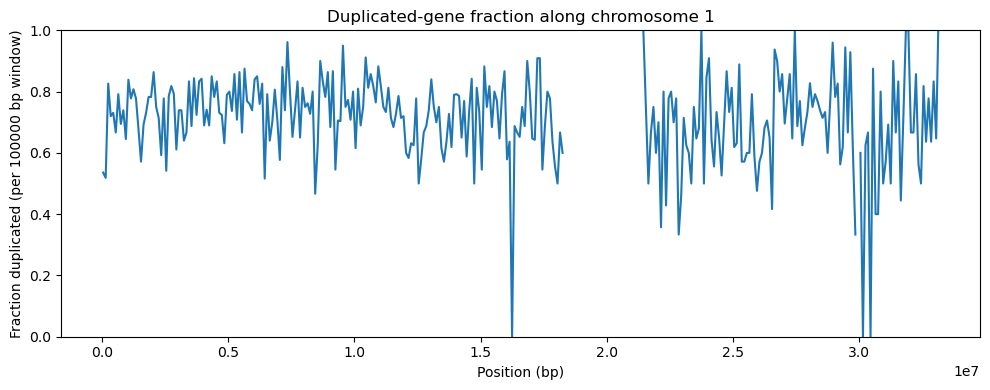

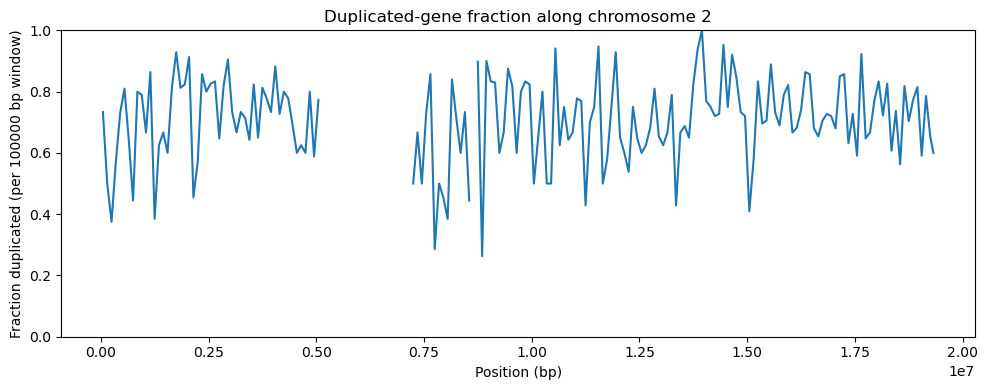

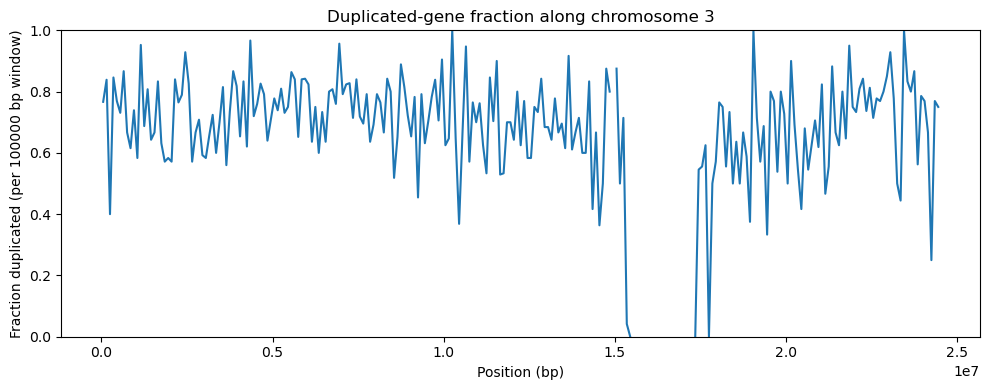

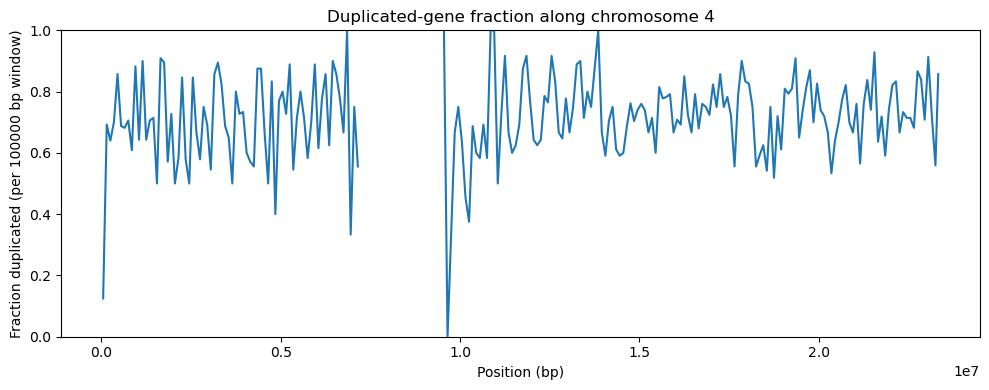

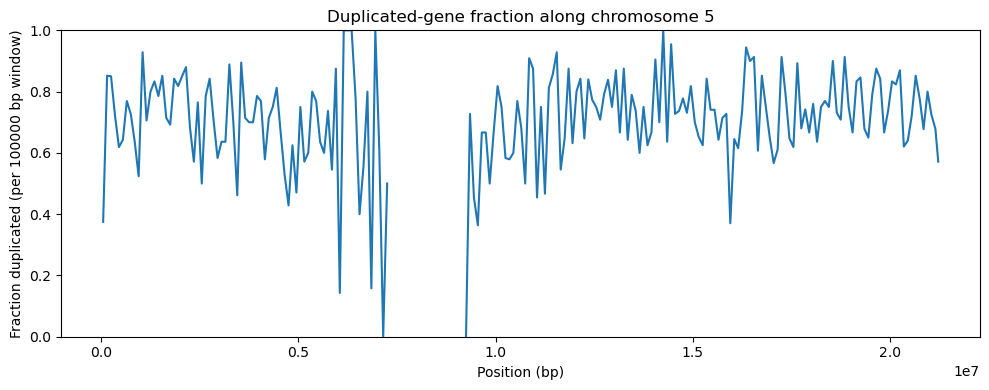

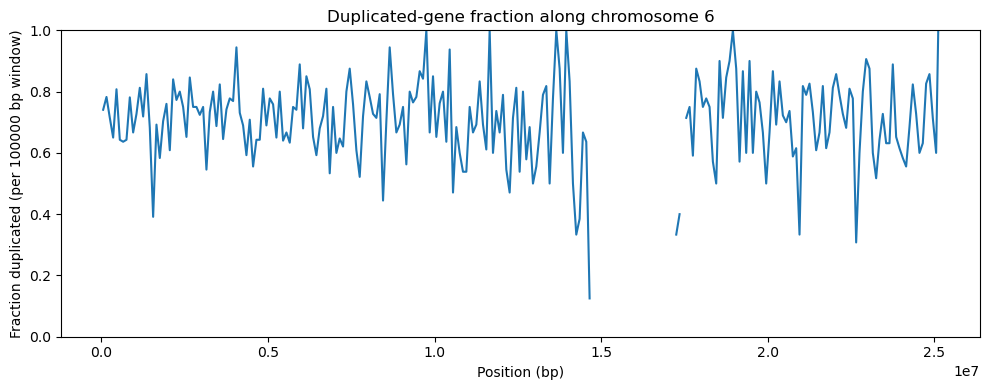

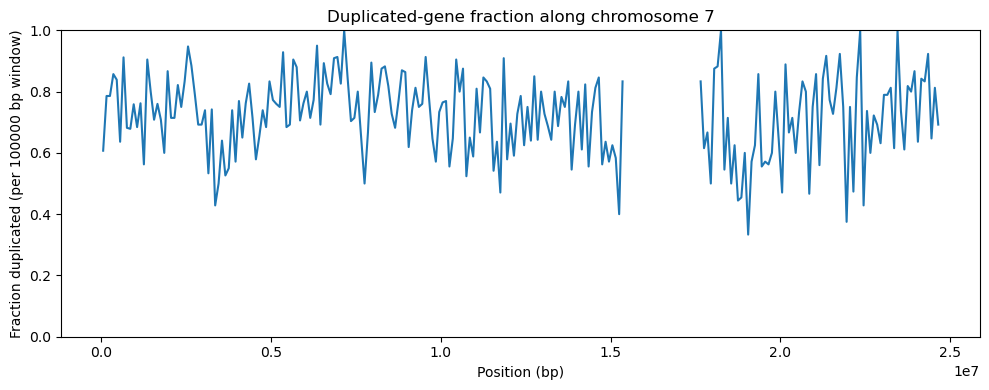

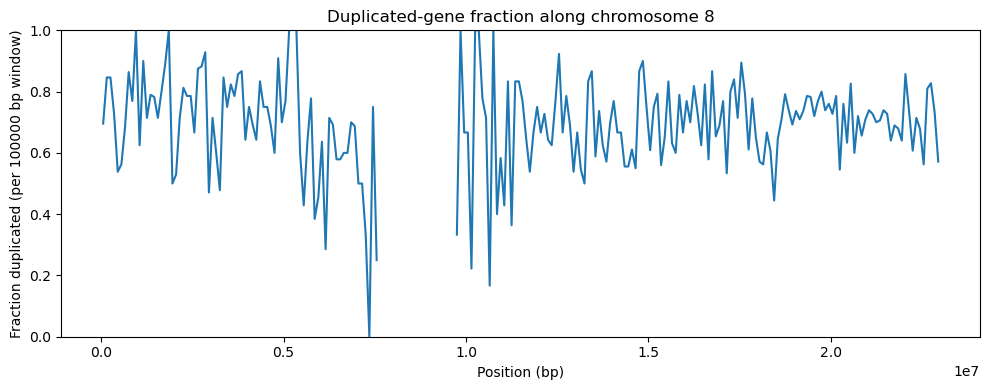

[OK] Saved profiles for 8 chromosomes (files: dup_fraction_chrX_win100000.png)


In [3]:
# window parameters
WINDOW_SIZE = 100_000   # 100 kb
N_PERM = 2000
SEED = 42

# major chromosomes
MAIN_CHROMS = [str(i) for i in range(1, 9)]  # "1".."8"

# =========================
# 1) READ THE LIST OF DUPLICATES
# =========================
clusters = pd.read_csv(
    CLUST_FILE,
    sep=r"\s+",
    header=None,
    names=["gene_id", "dup_group"],
    dtype={"gene_id": str, "dup_group": str}
)

# normalize the ID: remove the gene prefix:
clusters["gene_id_clean"] = clusters["gene_id"].str.replace(r"^gene:", "", regex=True)

dup_set = set(clusters["gene_id_clean"].dropna().astype(str))

print(f"[OK] clusters loaded: {len(clusters):,} rows")
print(f"[OK] duplicated gene IDs (unique): {len(dup_set):,}")

# =========================
# 2) chromosomes lengths from FASTA
# =========================
chrom_lengths = {}
for record in SeqIO.parse(genome_fasta, "fasta"):
    chrom_lengths[str(record.id)] = len(record.seq)

print(f"[OK] fasta sequences: {len(chrom_lengths):,}")
print("[INFO] example chrom IDs from FASTA:", list(chrom_lengths.keys())[:10])

# =========================
# 3) read GFF3 and make a list of genes with is_dup
# =========================
def parse_attributes(attr_str: str) -> dict:
    attrs = {}
    for part in str(attr_str).split(";"):
        part = part.strip()
        if "=" in part:
            k, v = part.split("=", 1)
            attrs[k] = v
    return attrs

open_func = gzip.open if gff_file.endswith(".gz") else open

genes = []
with open_func(gff_file, "rt") as f:
    for line in f:
        if not line.strip() or line.startswith("#"):
            continue
        cols = line.rstrip("\n").split("\t")
        if len(cols) != 9:
            continue

        chrom, source, feature, start, end, score, strand, phase, attr = cols

        # leave only the genes
        if feature != "gene":
            continue

        # throw away the scaffold (if there is one)
        if "scaffold" in chrom.lower():
            continue

        attrs = parse_attributes(attr)
        gene_id = attrs.get("ID", None)
        if gene_id is None:
            continue

        gene_id_clean = gene_id.replace("gene:", "")

        # to leave just chromosomes "1".."8" 
        if chrom not in MAIN_CHROMS:
            continue

        genes.append({
            "chr": chrom,
            "start": int(start),
            "end": int(end),
            "gene_id": gene_id_clean,
            "is_dup": gene_id_clean in dup_set
        })

genes_df = pd.DataFrame(genes)
print(f"[OK] genes loaded from GFF (main chroms only, no scaffolds): {len(genes_df):,}")
print(f"[OK] duplicated among them: {genes_df['is_dup'].sum():,} ({genes_df['is_dup'].mean()*100:.2f}%)")

# Quick check: are there genes on chr1?
if (genes_df["chr"] == "1").sum() == 0:
    print("[WARN] No genes on chr '1'. The names of the chromosomes may not be '1'..'8'.")
    print("       Look for unique chr in genes_df:", genes_df["chr"].unique()[:20])

# =========================
# 4) DUPLICATE WINDOW PROFILE 100 kb
# =========================
chrom_dup_profile = {}  # chr -> (positions, n_all, n_dup, frac)

for chrom in MAIN_CHROMS:
    if chrom not in chrom_lengths:
        # sometimes FASTA may have other IDs, but GFF is already filtered by MAIN_CHROMS
        # so we just skip it if there is no length
        continue

    sub = genes_df[genes_df["chr"] == chrom].copy()
    if sub.empty:
        continue

    chrom_len = chrom_lengths[chrom]
    n_windows = chrom_len // WINDOW_SIZE + 1

    n_all = np.zeros(n_windows, dtype=int)
    n_dup = np.zeros(n_windows, dtype=int)

    mids = ((sub["start"].to_numpy() + sub["end"].to_numpy()) // 2).astype(int)
    dups = sub["is_dup"].to_numpy(dtype=bool)

    for mid, is_dup in zip(mids, dups):
        b = mid // WINDOW_SIZE
        if 0 <= b < n_windows:
            n_all[b] += 1
            if is_dup:
                n_dup[b] += 1

    frac = np.full(n_windows, np.nan, dtype=float)
    mask = n_all > 0
    frac[mask] = n_dup[mask] / n_all[mask]

    positions = (np.arange(n_windows) + 0.5) * WINDOW_SIZE
    positions = np.minimum(positions, chrom_len - 1)

    chrom_dup_profile[chrom] = (positions, n_all, n_dup, frac)

    # graph
    plt.figure(figsize=(10, 4))
    plt.plot(positions, frac)
    plt.ylim(0, 1)
    plt.xlabel("Position (bp)")
    plt.ylabel(f"Fraction duplicated (per {WINDOW_SIZE} bp window)")
    plt.title(f"Duplicated-gene fraction along chromosome {chrom}")
    plt.tight_layout()

    plt.show()   


print(f"[OK] Saved profiles for {len(chrom_dup_profile)} chromosomes "
      f"(files: dup_fraction_chrX_win{WINDOW_SIZE}.png)")

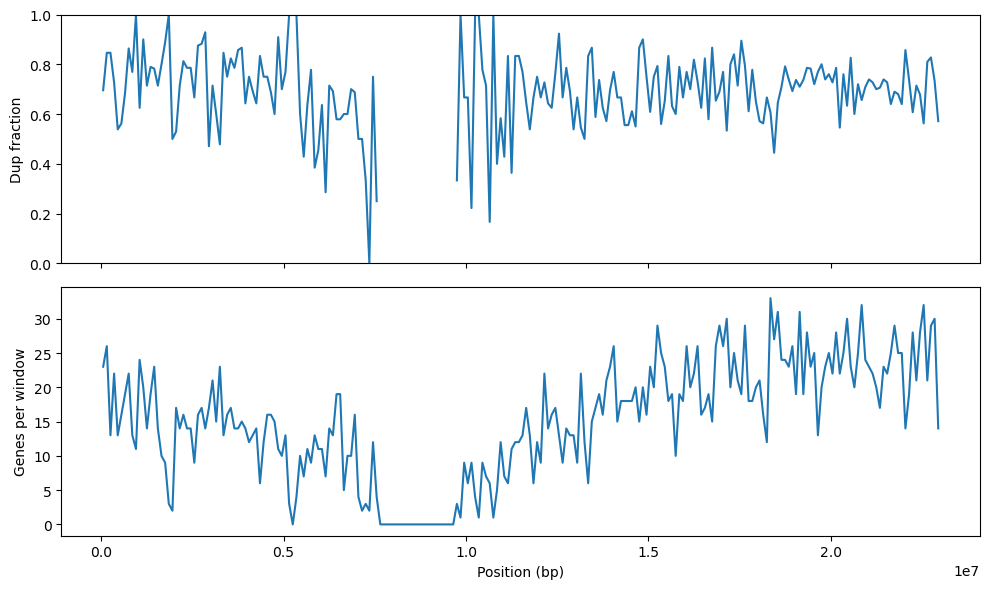

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10,6), sharex=True)

ax[0].plot(positions, frac)
ax[0].set_ylabel("Dup fraction")
ax[0].set_ylim(0,1)

ax[1].plot(positions, n_all)
ax[1].set_ylabel("Genes per window")
ax[1].set_xlabel("Position (bp)")

plt.tight_layout()
plt.show()

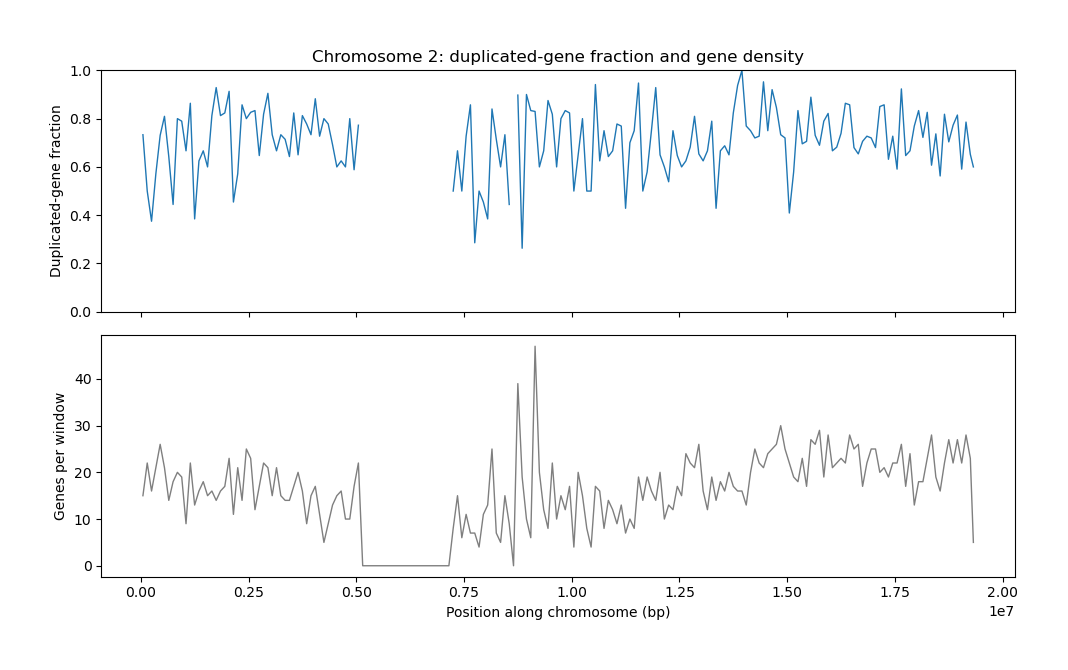

In [20]:
# ------------------------------------------------------------
# Two-panel linear plot for ONE chromosome (chromosome 2):
#   Top panel   : duplicated-gene fraction
#   Bottom panel: gene density (genes per window)
# ------------------------------------------------------------

# Select chromosome
chrom = "2"

# Extract data for chromosome 2
positions, n_all, n_dup, frac = chrom_dup_profile[chrom]

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ---- Top panel: duplicated-gene fraction ----
ax[0].plot(positions, frac, color="tab:blue", linewidth=1)
ax[0].set_ylabel("Duplicated-gene fraction")
ax[0].set_ylim(0, 1)
ax[0].set_title(
    f"Chromosome {chrom}: duplicated-gene fraction and gene density",
    fontsize=12
)

# ---- Bottom panel: gene density ----
ax[1].plot(positions, n_all, color="tab:gray", linewidth=1)
ax[1].set_ylabel("Genes per window")
ax[1].set_xlabel("Position along chromosome (bp)")

plt.tight_layout()
plt.show()


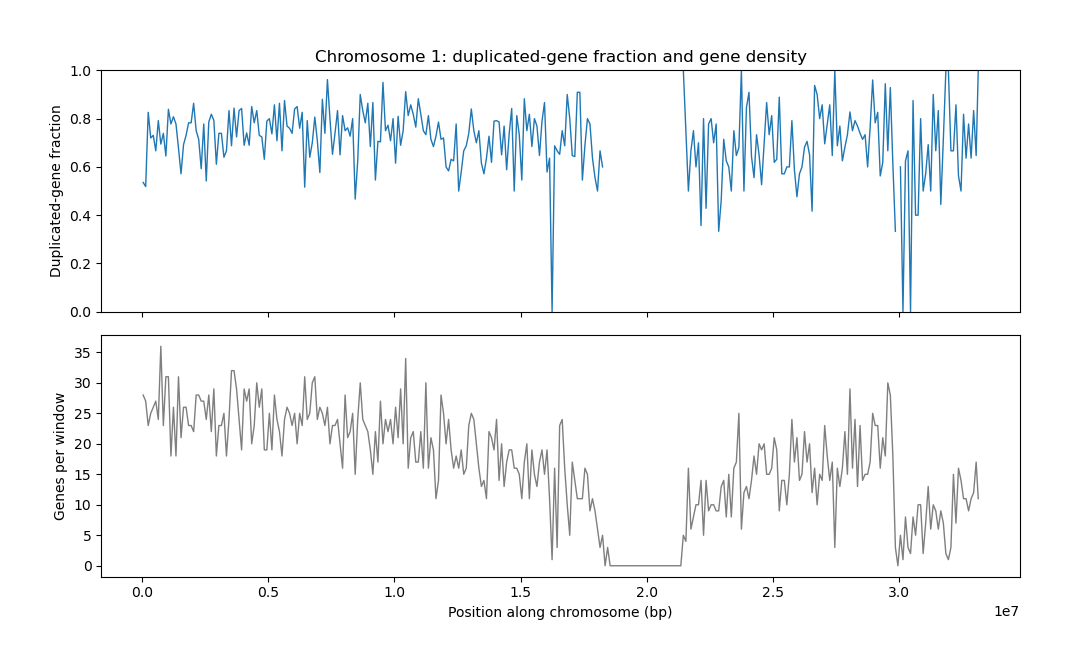

In [21]:
# Select chromosome
chrom = "1"

# Extract data for chromosome 2
positions, n_all, n_dup, frac = chrom_dup_profile[chrom]

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ---- Top panel: duplicated-gene fraction ----
ax[0].plot(positions, frac, color="tab:blue", linewidth=1)
ax[0].set_ylabel("Duplicated-gene fraction")
ax[0].set_ylim(0, 1)
ax[0].set_title(
    f"Chromosome {chrom}: duplicated-gene fraction and gene density",
    fontsize=12
)

# ---- Bottom panel: gene density ----
ax[1].plot(positions, n_all, color="tab:gray", linewidth=1)
ax[1].set_ylabel("Genes per window")
ax[1].set_xlabel("Position along chromosome (bp)")

plt.tight_layout()
plt.show()

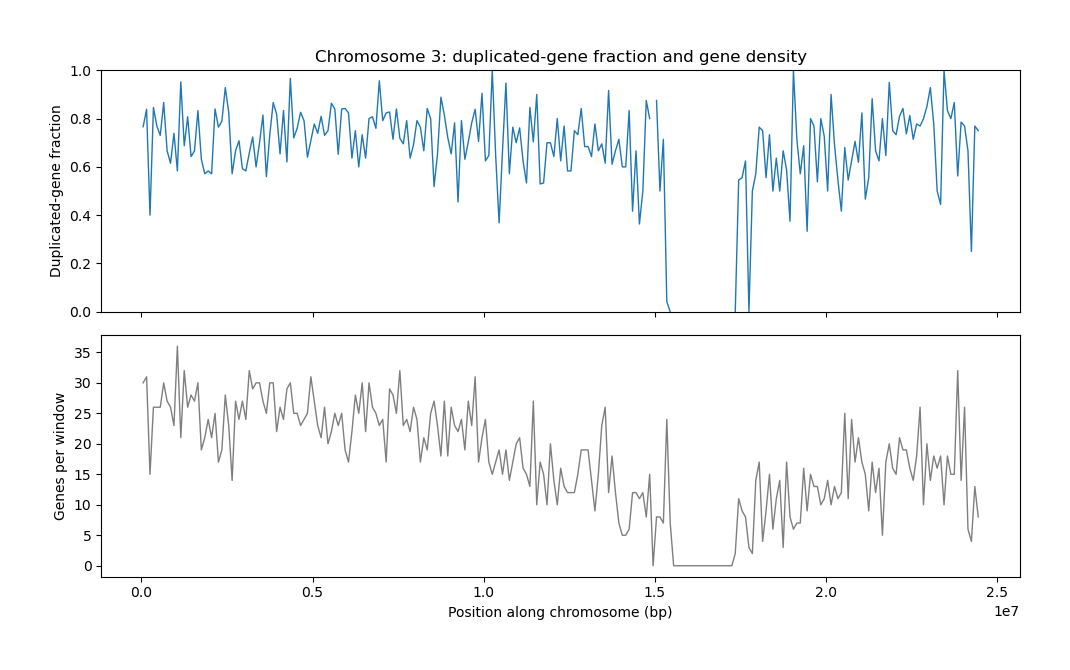

In [22]:
# Select chromosome
chrom = "3"

# Extract data for chromosome 2
positions, n_all, n_dup, frac = chrom_dup_profile[chrom]

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ---- Top panel: duplicated-gene fraction ----
ax[0].plot(positions, frac, color="tab:blue", linewidth=1)
ax[0].set_ylabel("Duplicated-gene fraction")
ax[0].set_ylim(0, 1)
ax[0].set_title(
    f"Chromosome {chrom}: duplicated-gene fraction and gene density",
    fontsize=12
)

# ---- Bottom panel: gene density ----
ax[1].plot(positions, n_all, color="tab:gray", linewidth=1)
ax[1].set_ylabel("Genes per window")
ax[1].set_xlabel("Position along chromosome (bp)")

plt.tight_layout()
plt.show()

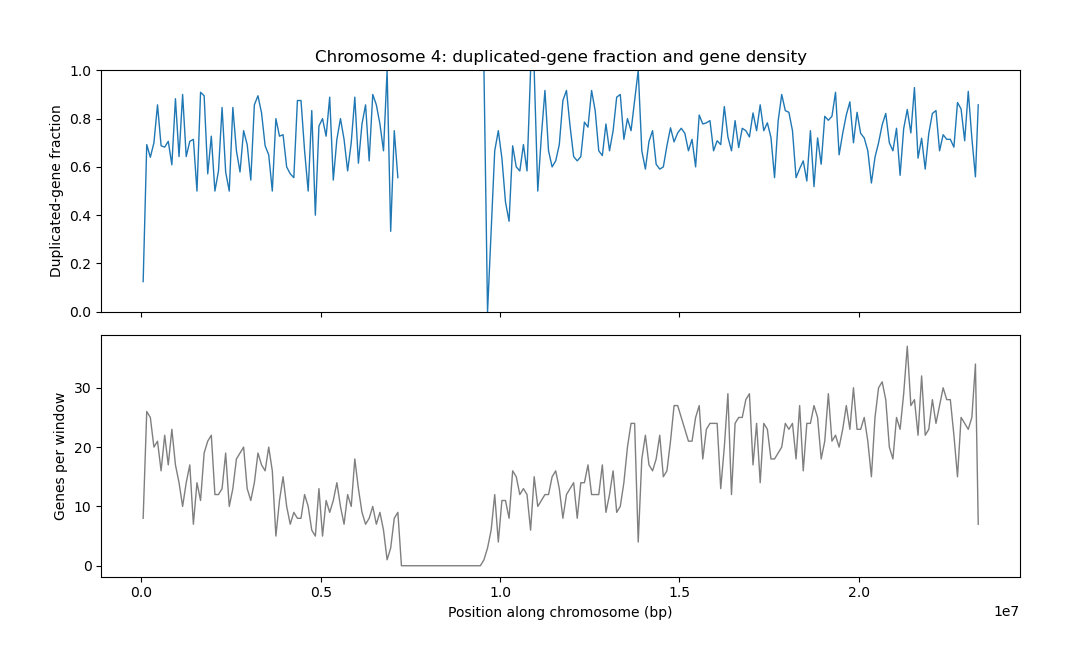

In [23]:
# Select chromosome
chrom = "4"

# Extract data for chromosome 2
positions, n_all, n_dup, frac = chrom_dup_profile[chrom]

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ---- Top panel: duplicated-gene fraction ----
ax[0].plot(positions, frac, color="tab:blue", linewidth=1)
ax[0].set_ylabel("Duplicated-gene fraction")
ax[0].set_ylim(0, 1)
ax[0].set_title(
    f"Chromosome {chrom}: duplicated-gene fraction and gene density",
    fontsize=12
)

# ---- Bottom panel: gene density ----
ax[1].plot(positions, n_all, color="tab:gray", linewidth=1)
ax[1].set_ylabel("Genes per window")
ax[1].set_xlabel("Position along chromosome (bp)")

plt.tight_layout()
plt.show()

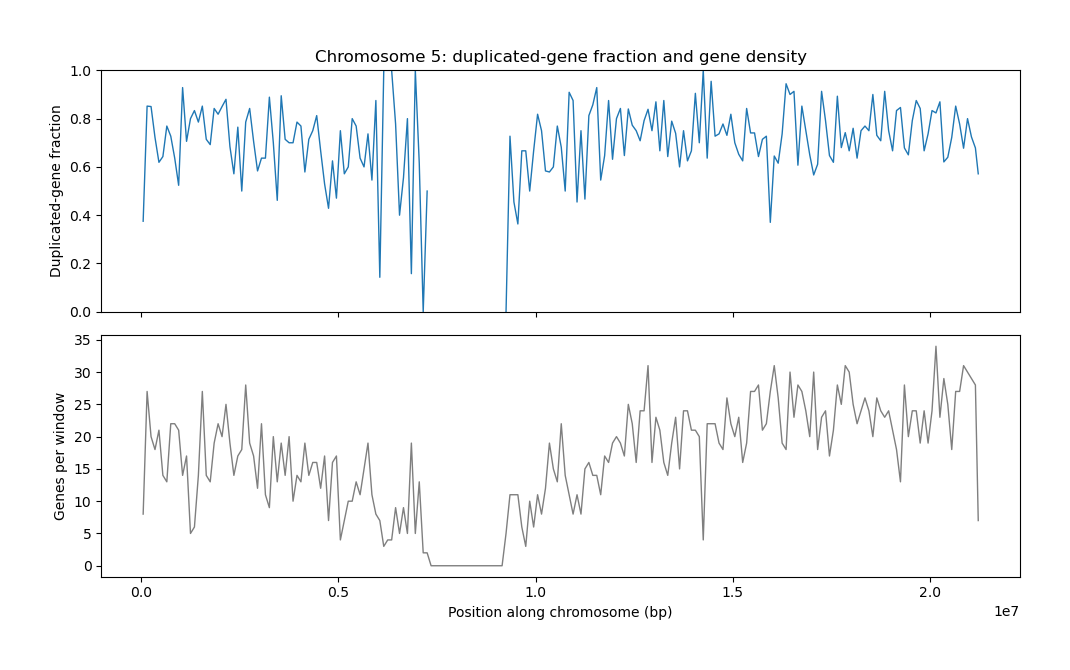

In [24]:
# Select chromosome
chrom = "5"

# Extract data for chromosome 2
positions, n_all, n_dup, frac = chrom_dup_profile[chrom]

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ---- Top panel: duplicated-gene fraction ----
ax[0].plot(positions, frac, color="tab:blue", linewidth=1)
ax[0].set_ylabel("Duplicated-gene fraction")
ax[0].set_ylim(0, 1)
ax[0].set_title(
    f"Chromosome {chrom}: duplicated-gene fraction and gene density",
    fontsize=12
)

# ---- Bottom panel: gene density ----
ax[1].plot(positions, n_all, color="tab:gray", linewidth=1)
ax[1].set_ylabel("Genes per window")
ax[1].set_xlabel("Position along chromosome (bp)")

plt.tight_layout()
plt.show()

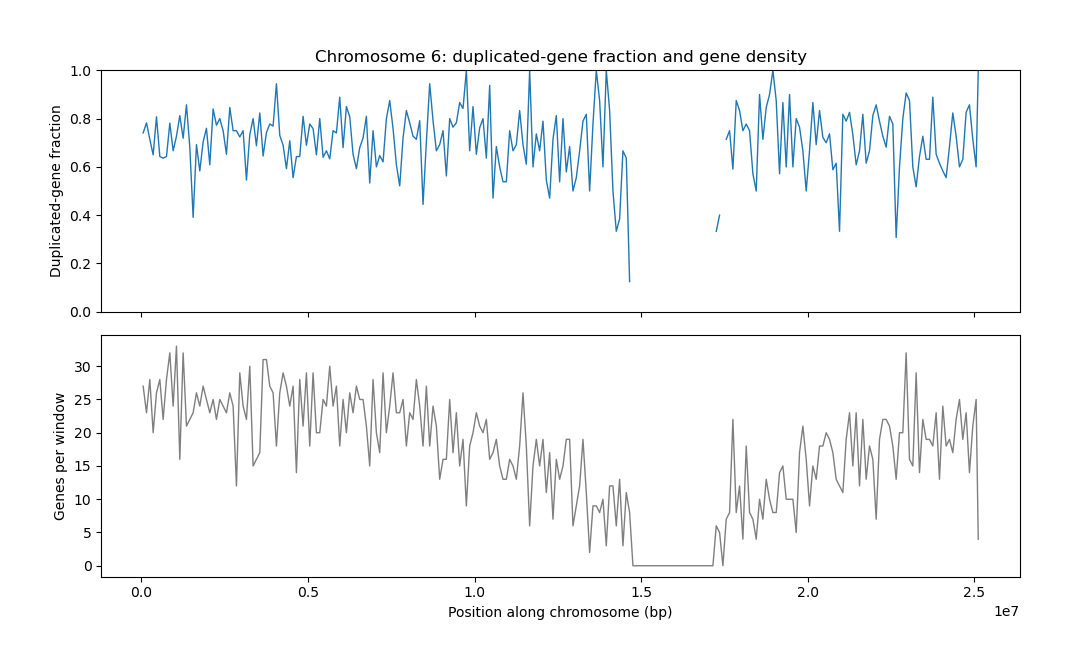

In [25]:
# Select chromosome
chrom = "6"

# Extract data for chromosome 2
positions, n_all, n_dup, frac = chrom_dup_profile[chrom]

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ---- Top panel: duplicated-gene fraction ----
ax[0].plot(positions, frac, color="tab:blue", linewidth=1)
ax[0].set_ylabel("Duplicated-gene fraction")
ax[0].set_ylim(0, 1)
ax[0].set_title(
    f"Chromosome {chrom}: duplicated-gene fraction and gene density",
    fontsize=12
)

# ---- Bottom panel: gene density ----
ax[1].plot(positions, n_all, color="tab:gray", linewidth=1)
ax[1].set_ylabel("Genes per window")
ax[1].set_xlabel("Position along chromosome (bp)")

plt.tight_layout()
plt.show()

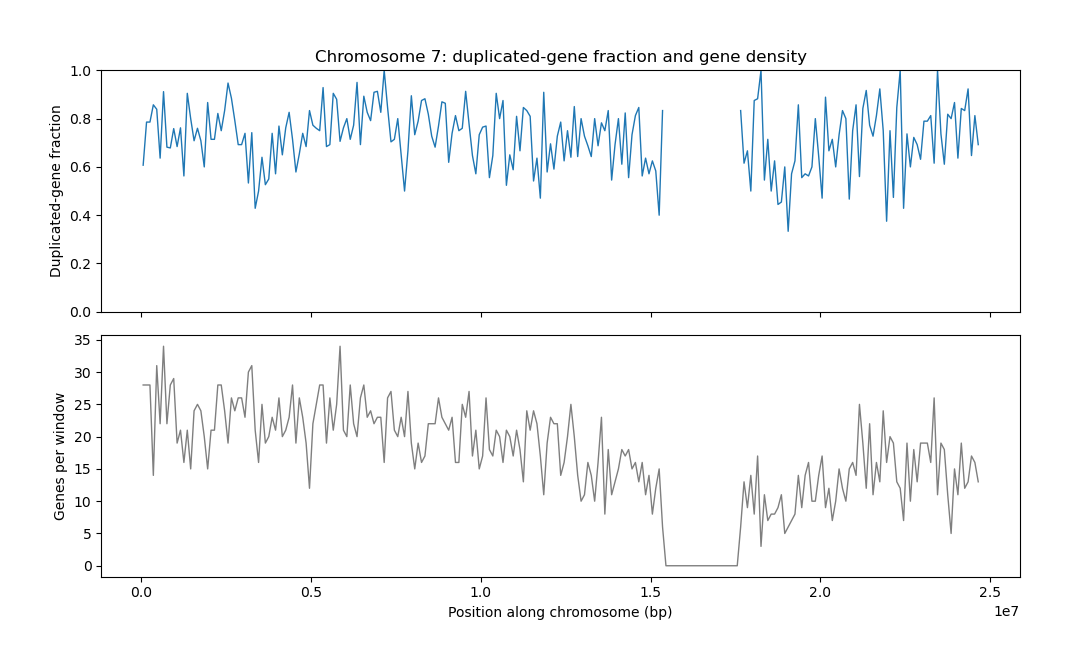

In [26]:
# Select chromosome
chrom = "7"

# Extract data for chromosome 2
positions, n_all, n_dup, frac = chrom_dup_profile[chrom]

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ---- Top panel: duplicated-gene fraction ----
ax[0].plot(positions, frac, color="tab:blue", linewidth=1)
ax[0].set_ylabel("Duplicated-gene fraction")
ax[0].set_ylim(0, 1)
ax[0].set_title(
    f"Chromosome {chrom}: duplicated-gene fraction and gene density",
    fontsize=12
)

# ---- Bottom panel: gene density ----
ax[1].plot(positions, n_all, color="tab:gray", linewidth=1)
ax[1].set_ylabel("Genes per window")
ax[1].set_xlabel("Position along chromosome (bp)")

plt.tight_layout()
plt.show()

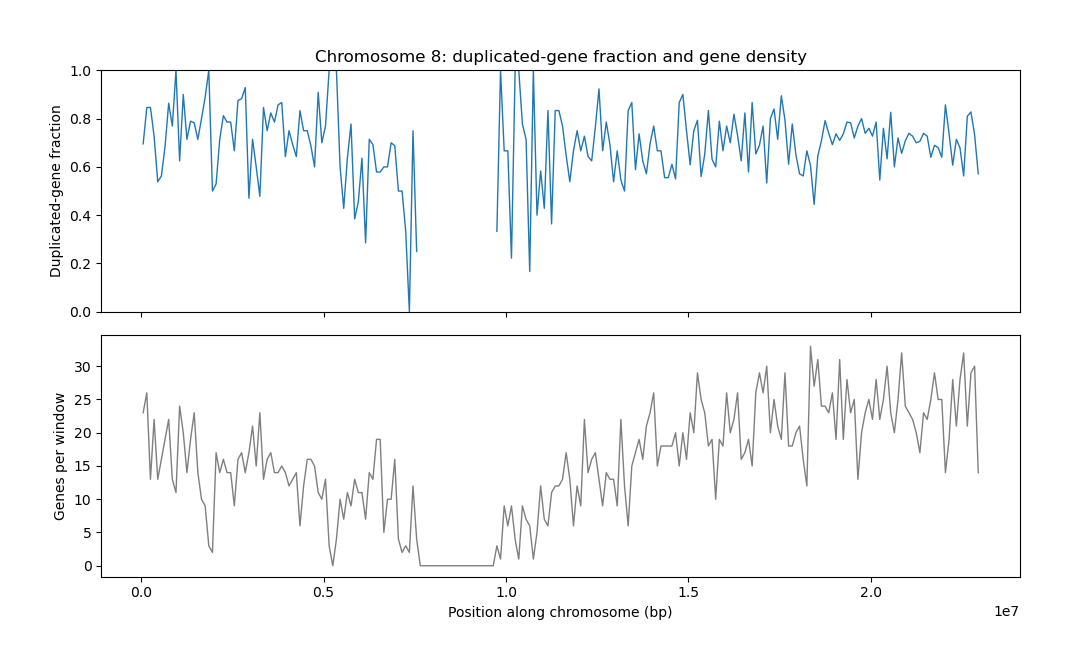

In [27]:
# Select chromosome
chrom = "8"

# Extract data for chromosome 2
positions, n_all, n_dup, frac = chrom_dup_profile[chrom]

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ---- Top panel: duplicated-gene fraction ----
ax[0].plot(positions, frac, color="tab:blue", linewidth=1)
ax[0].set_ylabel("Duplicated-gene fraction")
ax[0].set_ylim(0, 1)
ax[0].set_title(
    f"Chromosome {chrom}: duplicated-gene fraction and gene density",
    fontsize=12
)

# ---- Bottom panel: gene density ----
ax[1].plot(positions, n_all, color="tab:gray", linewidth=1)
ax[1].set_ylabel("Genes per window")
ax[1].set_xlabel("Position along chromosome (bp)")

plt.tight_layout()
plt.show()

In [5]:
# 5) PERMUTATION TEST: CLUSTERING ALONG THE CHROMOSOMES
#    (we mix the is_dup labels INSIDE each chromosome)
# =========================
def perm_test_local_clustering_bp(mids, labels, chrom_len, window_size=100_000, n_perm=2000, seed=42):
    rng = np.random.default_rng(seed)
    n_windows = chrom_len // window_size + 1

    # We read the dispersion of the proportion of duplicates by windows (ignoring empty windows)
    def stat(lbl):
        n_all = np.zeros(n_windows, dtype=int)
        n_dup = np.zeros(n_windows, dtype=int)
        for mid, is_dup in zip(mids, lbl):
            b = mid // window_size
            if 0 <= b < n_windows:
                n_all[b] += 1
                n_dup[b] += int(is_dup)
        mask = n_all > 0
        frac = n_dup[mask] / n_all[mask]
        if len(frac) < 2:
            return np.nan
        return np.var(frac, ddof=1)

    obs = stat(labels)
    if np.isnan(obs):
        return np.nan, np.nan

    perm_stats = np.empty(n_perm, dtype=float)
    for i in range(n_perm):
        perm_lbl = rng.permutation(labels)  # maintains the number of duplicates on the chromosome
        perm_stats[i] = stat(perm_lbl)

    p = (np.sum(perm_stats >= obs) + 1) / (n_perm + 1)
    return obs, p

rows = []
for chrom in MAIN_CHROMS:
    if chrom not in chrom_lengths:
        continue
    sub = genes_df[genes_df["chr"] == chrom].copy()
    if sub.empty:
        continue

    chrom_len = chrom_lengths[chrom]
    mids = ((sub["start"].to_numpy() + sub["end"].to_numpy()) // 2).astype(int)
    labels = sub["is_dup"].to_numpy(dtype=bool)

    obs_var, pval = perm_test_local_clustering_bp(
        mids, labels, chrom_len,
        window_size=WINDOW_SIZE,
        n_perm=N_PERM,
        seed=SEED
    )

    rows.append({
        "chr": chrom,
        "n_genes": len(sub),
        "dup_genes": int(labels.sum()),
        "dup_fraction": float(labels.mean()),
        "window_size_bp": WINDOW_SIZE,
        "obs_var_frac_windows": obs_var,
        "p_value": pval
    })

res_df = pd.DataFrame(rows).sort_values("p_value")
res_df.to_csv(f"perm_test_local_clustering_win{WINDOW_SIZE}.tsv", sep="\t", index=False)

print("\n[RESULT] Permutation test (local clustering along chromosome):")
print(res_df)

print(f"\n[OK] Saved table: perm_test_local_clustering_win{WINDOW_SIZE}.tsv")


[RESULT] Permutation test (local clustering along chromosome):
  chr  n_genes  dup_genes  dup_fraction  window_size_bp  obs_var_frac_windows  \
2   3     4216       3001      0.711812          100000              0.026106   
4   5     3470       2504      0.721614          100000              0.025589   
6   7     4113       2996      0.728422          100000              0.017128   
1   2     3006       2170      0.721890          100000              0.019276   
5   6     4177       2961      0.708882          100000              0.018470   
0   1     5380       3894      0.723792          100000              0.020598   
3   4     3640       2622      0.720330          100000              0.019615   
7   8     3476       2430      0.699079          100000              0.023708   

    p_value  
2  0.000500  
4  0.000500  
6  0.001999  
1  0.003498  
5  0.009995  
0  0.033483  
3  0.072464  
7  0.084958  

[OK] Saved table: perm_test_local_clustering_win100000.tsv


In [6]:
perm_test = pd.read_csv(
    "perm_test_local_clustering_win100000.tsv",
    sep="\t"
)

perm_test.head()

chr  n_genes  dup_genes  dup_fraction  window_size_bp  \
0    3     4216       3001      0.711812          100000   
1    5     3470       2504      0.721614          100000   
2    7     4113       2996      0.728422          100000   
3    2     3006       2170      0.721890          100000   
4    6     4177       2961      0.708882          100000   

   obs_var_frac_windows   p_value  
0              0.026106  0.000500  
1              0.025589  0.000500  
2              0.017128  0.001999  
3              0.019276  0.003498  
4              0.018470  0.009995

In [33]:
perm_test = pd.read_csv(
   "perm_test_local_clustering_win100000.tsv",
    sep="\t"
)

# ensure chromosome order 1..8
perm_test["chr"] =perm_test["chr"].astype(int)
perm_test = perm_test.sort_values("chr").reset_index(drop=True)

perm_test.head(8)


chr  n_genes  dup_genes  dup_fraction  window_size_bp  \
0    1     5380       3894      0.723792          100000   
1    2     3006       2170      0.721890          100000   
2    3     4216       3001      0.711812          100000   
3    4     3640       2622      0.720330          100000   
4    5     3470       2504      0.721614          100000   
5    6     4177       2961      0.708882          100000   
6    7     4113       2996      0.728422          100000   
7    8     3476       2430      0.699079          100000   

   obs_var_frac_windows   p_value  
0              0.020598  0.033483  
1              0.019276  0.003498  
2              0.026106  0.000500  
3              0.019615  0.072464  
4              0.025589  0.000500  
5              0.018470  0.009995  
6              0.017128  0.001999  
7              0.023708  0.084958

In [7]:
# ============================================================
# Permutation-based within-chromosome clustering analysis
# + robustness across multiple window sizes
# + filtering low-gene windows
# + hotspot detection (window-level enrichment) with FDR
#
# EXPECTED INPUTS (already in your notebook/script):
#   genes_df: pandas DataFrame with columns:
#       - chr   (e.g. "1".."8")
#       - start (int)
#       - end   (int)
#       - is_dup (bool; True=duplicated, False=singleton)
#   chrom_lengths: dict { "1": length_bp, ..., "8": length_bp }
#
# OUTPUTS:
#   1) permutation_summary.tsv : per-chromosome results for each window size
#   2) hotspot_windows_win{W}.tsv : window-level hotspots for each window size (all chromosomes)
#   3) plots:
#        - dup_fraction_profile_chr{chr}_win{W}.png (duplicate fraction vs position)
#        - hotspot_profile_chr{chr}_win{W}.png (duplicate fraction + hotspot marks)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

# ----------------------------
# User-configurable parameters
# ----------------------------
MAIN_CHROMS = [str(i) for i in range(1, 9)]

WINDOW_SIZES = [50_000, 100_000, 200_000]   # robustness: 50 kb, 100 kb, 200 kb
N_PERM = 5000                               # permutations per chromosome
SEED = 42

MIN_GENES_PER_WINDOW = 5                   # filter: ignore windows with too few genes
MIN_WINDOWS_REQUIRED = 5                   # skip chromosomes with too few valid windows

HOTSPOT_SIDE = "high"                      # "high" for enrichment of duplicates
HOTSPOT_TEST = "binom_perm"                # "binom_perm" (recommended): permutation p-values per window
HOTSPOT_N_PERM = 5000                      # permutations per chromosome for hotspot p-values
HOTSPOT_ALPHA_FDR = 0.05                   # FDR threshold

# ----------------------------
# Helpers
# ----------------------------

def get_gene_mids_and_labels(df_chr: pd.DataFrame):
    """Return midpoints and duplicate labels for one chromosome."""
    mids = ((df_chr["start"].to_numpy() + df_chr["end"].to_numpy()) // 2).astype(int)
    labels = df_chr["is_dup"].to_numpy(dtype=bool)
    return mids, labels

def window_counts_from_mids(mids, labels, chrom_len, window_size):
    """
    Compute per-window counts:
      n_all: total genes per window
      n_dup: duplicated genes per window
    """
    n_windows = chrom_len // window_size + 1
    n_all = np.zeros(n_windows, dtype=int)
    n_dup = np.zeros(n_windows, dtype=int)

    # Assign each gene to a window by its midpoint
    for m, d in zip(mids, labels):
        w = m // window_size
        if 0 <= w < n_windows:
            n_all[w] += 1
            n_dup[w] += int(d)

    return n_all, n_dup

def window_positions(chrom_len, window_size):
    """Return array of window-center positions in bp."""
    n_windows = chrom_len // window_size + 1
    pos = (np.arange(n_windows) + 0.5) * window_size
    pos = np.minimum(pos, chrom_len - 1)
    return pos

def perm_test_clustering_var(n_all, n_dup, min_genes=5, n_perm=5000, seed=42):
    """
    Permutation test for within-chromosome clustering using:
      statistic = variance of duplicate fraction across valid windows.
    We permute duplicate labels among genes within the chromosome, preserving #duplicates.
    """
    rng = np.random.default_rng(seed)

    # Valid windows: enough genes to make fraction stable
    valid = n_all >= min_genes
    if valid.sum() < MIN_WINDOWS_REQUIRED:
        return np.nan, np.nan, int(valid.sum())

    frac_obs = n_dup[valid] / n_all[valid]
    stat_obs = np.var(frac_obs, ddof=1)

    # Build gene-level representation for permutations
    n_genes = int(n_all.sum())
    n_dup_total = int(n_dup.sum())

    # Create an array of window indices for each gene (length n_genes)
    # This lets us count per-window duplicates fast during permutations.
    gene_window_idx = np.repeat(np.arange(len(n_all)), n_all)

    perm_stats = np.empty(n_perm, dtype=float)
    for i in range(n_perm):
        # Randomly select which genes are duplicates (preserve total duplicates)
        dup_gene_flags = np.zeros(n_genes, dtype=bool)
        dup_gene_flags[rng.choice(n_genes, size=n_dup_total, replace=False)] = True

        # Count duplicates per window under this permutation
        n_dup_perm = np.bincount(gene_window_idx, weights=dup_gene_flags.astype(int), minlength=len(n_all)).astype(int)

        # Compute permuted statistic on valid windows only
        frac_perm = n_dup_perm[valid] / n_all[valid]
        perm_stats[i] = np.var(frac_perm, ddof=1)

    p_value = (np.sum(perm_stats >= stat_obs) + 1) / (n_perm + 1)
    return float(stat_obs), float(p_value), int(valid.sum())

def hotspot_pvalues_by_permutation(n_all, n_dup, min_genes=5, n_perm=5000, seed=42, side="high"):
    """
    Window-level hotspot detection with permutation p-values.
    For each permutation, duplicates are randomly reassigned among genes within chromosome.
    For each window, we compute an empirical p-value:
      p = Pr(dup_count_perm >= dup_count_obs) for side="high"
      p = Pr(dup_count_perm <= dup_count_obs) for side="low"
    """
    rng = np.random.default_rng(seed)

    valid = n_all >= min_genes
    n_windows = len(n_all)

    # If too few valid windows, return empty
    if valid.sum() < MIN_WINDOWS_REQUIRED:
        pvals = np.full(n_windows, np.nan, dtype=float)
        return pvals, valid

    n_genes = int(n_all.sum())
    n_dup_total = int(n_dup.sum())
    gene_window_idx = np.repeat(np.arange(n_windows), n_all)

    # We will count how many permutations are as extreme as observed for each window
    more_extreme = np.zeros(n_windows, dtype=int)

    for _ in range(n_perm):
        dup_gene_flags = np.zeros(n_genes, dtype=bool)
        dup_gene_flags[rng.choice(n_genes, size=n_dup_total, replace=False)] = True
        n_dup_perm = np.bincount(gene_window_idx, weights=dup_gene_flags.astype(int), minlength=n_windows).astype(int)

        if side == "high":
            more_extreme += (n_dup_perm >= n_dup).astype(int)
        else:
            more_extreme += (n_dup_perm <= n_dup).astype(int)

    # +1 correction for permutation p-values
    pvals = (more_extreme + 1) / (n_perm + 1)
    pvals[~valid] = np.nan
    return pvals, valid

def plot_profile(chrom, window_size, positions, frac, n_all, hotspots_mask=None, outfile=None):
    """
    Plot duplicate fraction along chromosome.
    Optionally mark hotspot windows.
    """
    plt.figure(figsize=(11, 4))
    plt.plot(positions, frac)
    plt.ylim(0, 1)
    plt.xlabel("Position (bp)")
    plt.ylabel(f"Duplicate fraction (per {window_size} bp window)")
    plt.title(f"Chromosome {chrom}: duplicate fraction profile")

    # Mark hotspots if provided
    if hotspots_mask is not None and np.any(hotspots_mask):
        plt.scatter(positions[hotspots_mask], frac[hotspots_mask], marker="o")

    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=300)
        plt.close()
    else:
        plt.show()

# ----------------------------
# Main analysis
# ----------------------------

all_summary_rows = []
all_hotspot_rows = []

rng_master = np.random.default_rng(SEED)

for W in WINDOW_SIZES:
    print(f"\n=== Window size: {W} bp ===")

    for chrom in MAIN_CHROMS:
        if chrom not in chrom_lengths:
            continue

        df_chr = genes_df[genes_df["chr"] == chrom].copy()
        if df_chr.empty:
            continue

        chrom_len = chrom_lengths[chrom]
        mids, labels = get_gene_mids_and_labels(df_chr)

        # Compute observed per-window counts
        n_all, n_dup = window_counts_from_mids(mids, labels, chrom_len, W)
        pos = window_positions(chrom_len, W)

        # Duplicate fraction per window (NaN for empty windows)
        frac = np.full(len(n_all), np.nan, dtype=float)
        mask_nonzero = n_all > 0
        frac[mask_nonzero] = n_dup[mask_nonzero] / n_all[mask_nonzero]

        # 1) Permutation test for clustering (variance of window fractions)
        # Use a different seed per (chrom, W) to avoid identical RNG sequences
        local_seed = int(rng_master.integers(0, 2**31 - 1))
        obs_var, p_var, n_valid_windows = perm_test_clustering_var(
            n_all, n_dup,
            min_genes=MIN_GENES_PER_WINDOW,
            n_perm=N_PERM,
            seed=local_seed
        )

        # Save summary
        all_summary_rows.append({
            "chr": chrom,
            "window_size_bp": W,
            "min_genes_per_window": MIN_GENES_PER_WINDOW,
            "n_genes_total": int(n_all.sum()),
            "dup_genes_total": int(n_dup.sum()),
            "dup_fraction_total": float(n_dup.sum() / max(1, n_all.sum())),
            "n_windows_total": int(len(n_all)),
            "n_windows_used": int(n_valid_windows),
            "obs_var_frac_windows": obs_var,
            "p_value_perm_var": p_var
        })

        # 2) Hotspot detection (window-level enrichment with FDR)
        local_seed2 = int(rng_master.integers(0, 2**31 - 1))
        pvals_win, valid = hotspot_pvalues_by_permutation(
            n_all, n_dup,
            min_genes=MIN_GENES_PER_WINDOW,
            n_perm=HOTSPOT_N_PERM,
            seed=local_seed2,
            side=HOTSPOT_SIDE
        )

        # Apply FDR correction across windows WITHIN this chromosome
        # (only valid windows participate)
        valid_idx = np.where(valid)[0]
        if len(valid_idx) >= MIN_WINDOWS_REQUIRED:
            pvals_valid = pvals_win[valid_idx]
            # FDR (Benjamini-Hochberg)
            _, qvals_valid, _, _ = multipletests(pvals_valid, alpha=HOTSPOT_ALPHA_FDR, method="fdr_bh")
            qvals = np.full_like(pvals_win, np.nan, dtype=float)
            qvals[valid_idx] = qvals_valid

            hotspots = (qvals <= HOTSPOT_ALPHA_FDR)
        else:
            qvals = np.full_like(pvals_win, np.nan, dtype=float)
            hotspots = np.zeros_like(valid, dtype=bool)

        # Store hotspot windows
        for w_idx in np.where(hotspots)[0]:
            start_bp = int(w_idx * W)
            end_bp = int(min((w_idx + 1) * W, chrom_len))
            all_hotspot_rows.append({
                "chr": chrom,
                "window_size_bp": W,
                "window_index": int(w_idx),
                "start_bp": start_bp,
                "end_bp": end_bp,
                "genes_in_window": int(n_all[w_idx]),
                "dup_genes_in_window": int(n_dup[w_idx]),
                "dup_fraction_window": float(n_dup[w_idx] / n_all[w_idx]) if n_all[w_idx] > 0 else np.nan,
                "p_perm_window": float(pvals_win[w_idx]) if not np.isnan(pvals_win[w_idx]) else np.nan,
                "q_fdr_window": float(qvals[w_idx]) if not np.isnan(qvals[w_idx]) else np.nan
            })

        # 3) Save plots for this chromosome and window size
        # (A) plain profile
        out1 = f"dup_fraction_profile_chr{chrom}_win{W}.png"
        plot_profile(chrom, W, pos, frac, n_all, hotspots_mask=None, outfile=out1)

        # (B) profile with hotspot marks
        out2 = f"hotspot_profile_chr{chrom}_win{W}.png"
        plot_profile(chrom, W, pos, frac, n_all, hotspots_mask=hotspots, outfile=out2)

        # Console feedback
        n_hot = int(np.nansum(hotspots.astype(int)))
        print(f"chr {chrom}: p_var={p_var:.4g}, obs_var={obs_var:.6g}, hotspots={n_hot}")

# ----------------------------
# Save outputs
# ----------------------------
summary_df = pd.DataFrame(all_summary_rows).sort_values(["window_size_bp", "p_value_perm_var"])
summary_df.to_csv("permutation_summary.tsv", sep="\t", index=False)
print("\n[OK] Saved per-chromosome permutation summary: permutation_summary.tsv")

hotspots_df = pd.DataFrame(all_hotspot_rows).sort_values(["window_size_bp", "chr", "start_bp"])
hotspots_df.to_csv("hotspot_windows_all.tsv", sep="\t", index=False)
print("[OK] Saved hotspot windows (all chromosomes, all window sizes): hotspot_windows_all.tsv")

# ----------------------------
# 
# ----------------------------
print("\n=== Draft Results paragraph (English) ===")
print(
    "A permutation-based sliding-window analysis revealed that duplicated genes are non-randomly distributed along "
    "chromosomes. For each chromosome, we computed the variance of the duplicated-gene fraction across genomic windows "
    f"and compared it to a null distribution generated by randomly permuting duplicate labels among genes within the "
    f"same chromosome (preserving the total number of duplicated genes). To reduce instability in gene-poor regions, "
    f"windows containing fewer than {MIN_GENES_PER_WINDOW} genes were excluded. The clustering signal was robust across "
    f"multiple window sizes ({', '.join(str(w) for w in WINDOW_SIZES)} bp). In addition, we identified local hotspot "
    f"windows enriched for duplicated genes using window-level permutation p-values followed by Benjamini–Hochberg FDR "
    f"correction (q ≤ {HOTSPOT_ALPHA_FDR})."
)



=== Window size: 50000 bp ===
chr 1: p_var=0.007399, obs_var=0.0259366, hotspots=0
chr 2: p_var=0.0005999, obs_var=0.0296477, hotspots=0
chr 3: p_var=0.002599, obs_var=0.0271934, hotspots=0
chr 4: p_var=0.03339, obs_var=0.0262966, hotspots=0
chr 5: p_var=0.0002, obs_var=0.030734, hotspots=0
chr 6: p_var=0.008798, obs_var=0.0260612, hotspots=0
chr 7: p_var=0.0005999, obs_var=0.0282947, hotspots=0
chr 8: p_var=0.4061, obs_var=0.02442, hotspots=0

=== Window size: 100000 bp ===
chr 1: p_var=0.06079, obs_var=0.0146887, hotspots=0
chr 2: p_var=0.0018, obs_var=0.0188445, hotspots=0
chr 3: p_var=0.0002, obs_var=0.0212413, hotspots=0
chr 4: p_var=0.1114, obs_var=0.0157722, hotspots=0
chr 5: p_var=0.0002, obs_var=0.0218909, hotspots=0
chr 6: p_var=0.0007998, obs_var=0.0177837, hotspots=0
chr 7: p_var=0.002, obs_var=0.0168599, hotspots=0
chr 8: p_var=0.05139, obs_var=0.0165828, hotspots=0

=== Window size: 200000 bp ===
chr 1: p_var=0.0216, obs_var=0.00901671, hotspots=0
chr 2: p_var=0.0009998,

In [32]:
perm_summary = pd.read_csv(
    "permutation_summary.tsv",
    sep="\t"
)

# ensure chromosome order 1..8
perm_summary["chr"] = perm_summary["chr"].astype(int)
perm_summary = perm_summary.sort_values("chr").reset_index(drop=True)

perm_summary.head(8)


chr  window_size_bp  min_genes_per_window  n_genes_total  dup_genes_total  \
0    1          200000                     5           5380             3894   
1    1          100000                     5           5380             3894   
2    1           50000                     5           5380             3894   
3    2          200000                     5           3006             2170   
4    2          100000                     5           3006             2170   
5    2           50000                     5           3006             2170   
6    3          100000                     5           4216             3001   
7    3          200000                     5           4216             3001   

   dup_fraction_total  n_windows_total  n_windows_used  obs_var_frac_windows  \
0            0.723792              166             149              0.009017   
1            0.723792              332             287              0.014689   
2            0.723792              663             509              0.025937   
3            0.721890               97              87              0.010633   
4            0.721890              194             169              0.018844   
5            0.721890              387             290              0.029648   
6            0.711812              245             220              0.021241   
7            0.711812              123             114              0.015109   

   p_value_perm_var  
0          0.021596  
1          0.060788  
2          0.007399  
3          0.001000  
4          0.001800  
5          0.000600  
6          0.000200  
7          0.000200

In [19]:
hotspots_df=pd.read_csv("hotspot_windows_all.tsv", sep="\t")
hotspots_df.head()

chr  window_size_bp  window_index  start_bp    end_bp  genes_in_window  \
0    2          200000            69  13800000  14000000               32   

   dup_genes_in_window  dup_fraction_window  p_perm_window  q_fdr_window  
0                   31              0.96875         0.0004      0.034793

In [7]:
chrom_dup_profile[chrom] = (positions, n_all, n_dup, frac)

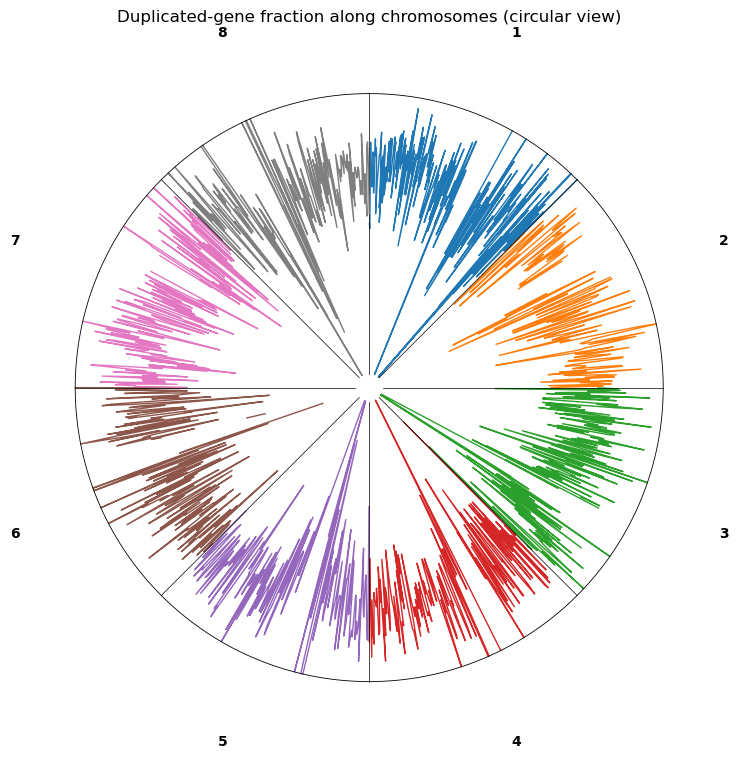

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Circular (circos-like) plot of duplicated-gene fraction
# One sector per chromosome, fraction plotted along the arc
# ------------------------------------------------------------

MAIN_CHROMS = [str(i) for i in range(1, 9)]

# Radius settings
INNER_RADIUS = 1.0
TRACK_WIDTH = 0.25

# Colors per chromosome (can be adjusted)
CHR_COLORS = {
    "1": "tab:blue",
    "2": "tab:orange",
    "3": "tab:green",
    "4": "tab:red",
    "5": "tab:purple",
    "6": "tab:brown",
    "7": "tab:pink",
    "8": "tab:gray"
}

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

ax.set_theta_direction(-1)     # clockwise
ax.set_theta_offset(np.pi / 2) # start at top

# Remove default polar decorations
ax.set_xticks([])
ax.set_yticks([])
ax.spines["polar"].set_visible(False)

# Total angle (2π) divided equally among chromosomes
n_chr = len(MAIN_CHROMS)
angle_per_chr = 2 * np.pi / n_chr

for i, chrom in enumerate(MAIN_CHROMS):
    if chrom not in chrom_dup_profile:
        continue

    positions, n_all, n_dup, frac = chrom_dup_profile[chrom]

    # Normalize genomic positions to [0, angle_per_chr]
    chrom_len = positions.max()
    theta = (positions / chrom_len) * angle_per_chr
    theta = theta + i * angle_per_chr

    # Radial values: map fraction [0,1] into a radial band
    r = INNER_RADIUS + frac * TRACK_WIDTH

    # Plot the profile
    ax.plot(
        theta,
        r,
        color=CHR_COLORS.get(chrom, "black"),
        linewidth=1
    )

    # Draw chromosome boundary lines
    ax.plot(
        [i * angle_per_chr, i * angle_per_chr],
        [INNER_RADIUS, INNER_RADIUS + TRACK_WIDTH],
        color="black",
        linewidth=0.5
    )

    # Add chromosome label
    label_angle = i * angle_per_chr + angle_per_chr / 2
    ax.text(
        label_angle,
        INNER_RADIUS + TRACK_WIDTH + 0.08,
        chrom,
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold"
    )

# Outer circle (track boundary)
theta_full = np.linspace(0, 2 * np.pi, 1000)
ax.plot(
    theta_full,
    np.full_like(theta_full, INNER_RADIUS + TRACK_WIDTH),
    color="black",
    linewidth=0.6
)

plt.title(
    "Duplicated-gene fraction along chromosomes (circular view)",
    y=1.08,
    fontsize=12
)

plt.show()


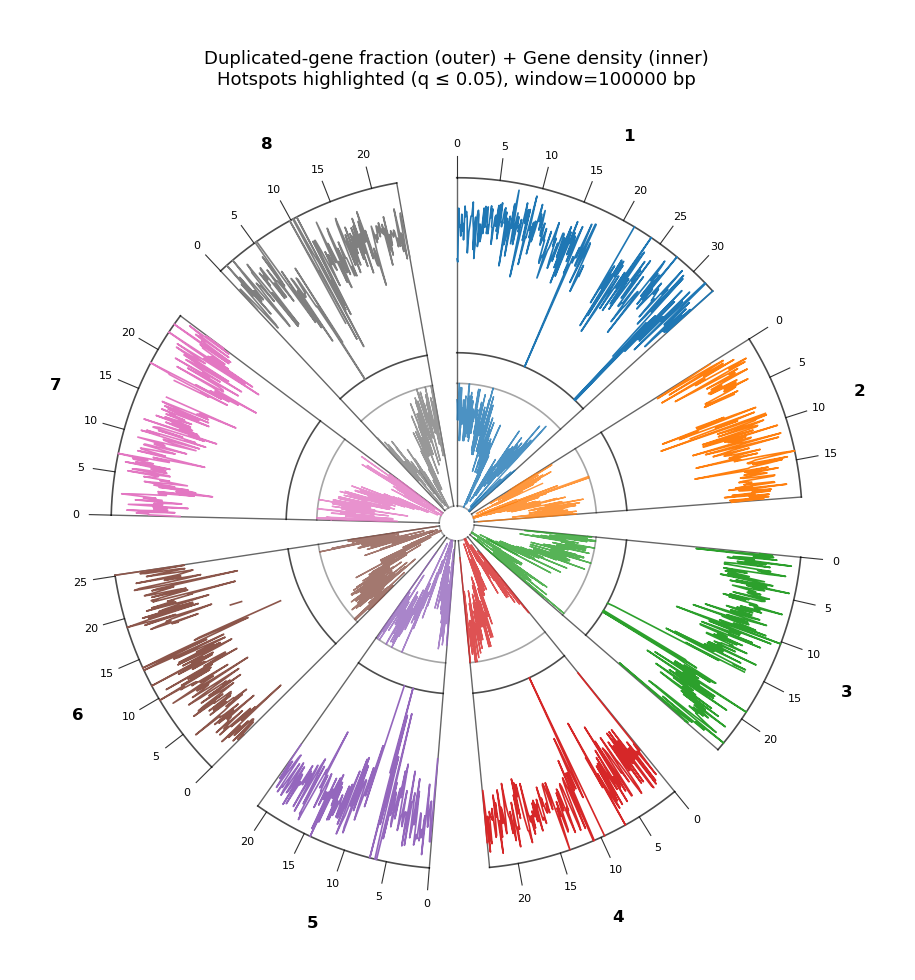

In [10]:
# ============================================================
# Circos-like (matplotlib polar) plot with:
#   1) Outer ring: duplicated-gene fraction (line) per chromosome sector
#   2) Inner ring: gene density (genes per window) per chromosome sector
#   3) Hotspot windows highlighted (markers) on the duplicated-fraction ring
#
# This is tuned to look closer to your "second" figure:
# - wide empty center
# - each chromosome occupies a wedge/sector (not a full ring track)
# - arc outline + tick labels (0, 5Mb, 10Mb, ...)
#
# REQUIRED INPUTS (already produced in your workflow):
#   chrom_dup_profile[chrom] = (positions, n_all, n_dup, frac)
#       positions: window centers (bp)
#       n_all: genes per window
#       frac: duplicated fraction per window (NaN if no genes)
#   chrom_lengths[chrom] = chromosome length (bp)
#
# OPTIONAL INPUT:
#   hotspots_df: DataFrame with hotspot windows (from your hotspot code)
#       columns expected:
#         - chr
#         - window_size_bp
#         - window_index
#         - q_fdr_window
#
# If you don't have hotspots_df yet, set hotspots_df = None.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Parameters you may adjust
# -----------------------------
MAIN_CHROMS = [str(i) for i in range(1, 9)]
WINDOW_SIZE_BP = 100_000          # must match your chrom_dup_profile window size

# Sector layout
START_ANGLE = np.pi / 2           # start at top
CLOCKWISE = True
GAP_RAD = np.deg2rad(10)          # gap between chromosome sectors (radians)

# Ring radii (make a big empty center like your second figure)
R_DUP_INNER = 1.25
R_DUP_OUTER = 1.65

R_DEN_INNER = 0.90
R_DEN_OUTER = 1.18

# Track styling
ARC_LW = 1.2
SECTOR_DIVIDER_LW = 1.0
LINE_LW = 1.2

# Tick styling (Mb)
TICK_INTERVAL = 5_000_000         # 5 Mb
TICK_LW = 0.8
TICK_LABEL_SIZE = 8

# Hotspots
HOTSPOT_Q_THRESHOLD = 0.05        # highlight windows with q <= 0.05
HOTSPOT_MARKER_SIZE = 18

# Chromosome colors (same as your earlier plot)
CHR_COLORS = {
    "1": "tab:blue",
    "2": "tab:orange",
    "3": "tab:green",
    "4": "tab:red",
    "5": "tab:purple",
    "6": "tab:brown",
    "7": "tab:pink",
    "8": "tab:gray"
}

# -----------------------------
# Hotspot lookup helper
# -----------------------------
def make_hotspot_lookup(hotspots_df, window_size_bp, q_thr=0.05):
    """
    Build dict: chrom -> set(window_index) for hotspot windows.
    If hotspots_df is None, return empty dict.
    """
    lookup = {c: set() for c in MAIN_CHROMS}
    if hotspots_df is None:
        return lookup

    df = hotspots_df.copy()
    df = df[df["window_size_bp"] == window_size_bp]
    df = df[df["q_fdr_window"] <= q_thr]
    for chrom, sub in df.groupby("chr"):
        lookup[str(chrom)] = set(sub["window_index"].astype(int).tolist())
    return lookup

# If you have hotspots_df from the hotspot script, keep it;
# otherwise set hotspots_df = None.
# hotspots_df = pd.read_csv("hotspot_windows_all.tsv", sep="\t")   # example
hotspot_lookup = make_hotspot_lookup(
    globals().get("hotspots_df", None),
    window_size_bp=WINDOW_SIZE_BP,
    q_thr=HOTSPOT_Q_THRESHOLD
)

# -----------------------------
# Utility: convert genomic x->theta inside a sector
# -----------------------------
def x_to_theta(x_bp, chrom_len, sector_start, sector_span):
    """Map genomic positions (bp) into polar angle theta in [sector_start, sector_start+sector_span]."""
    return sector_start + (x_bp / chrom_len) * sector_span

# -----------------------------
# Compute sector angles proportional to chromosome lengths
# (closer to many circos plots than equal wedges)
# -----------------------------
lengths = []
chroms_present = []
for c in MAIN_CHROMS:
    if c in chrom_lengths and c in chrom_dup_profile:
        chroms_present.append(c)
        lengths.append(chrom_lengths[c])

total_len = float(np.sum(lengths))
n = len(chroms_present)

# Total available angle excluding gaps
total_gap = n * GAP_RAD
available = 2 * np.pi - total_gap

# Sector spans proportional to chromosome length
sector_spans = {c: available * (chrom_lengths[c] / total_len) for c in chroms_present}

# Sector start angles
sector_starts = {}
theta_cursor = 0.0
for c in chroms_present:
    sector_starts[c] = theta_cursor
    theta_cursor += sector_spans[c] + GAP_RAD

# -----------------------------
# Create polar figure
# -----------------------------
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

ax.set_theta_direction(-1 if CLOCKWISE else 1)
ax.set_theta_offset(START_ANGLE)

ax.set_xticks([])
ax.set_yticks([])
ax.spines["polar"].set_visible(False)

# -----------------------------
# Draw each chromosome sector
# -----------------------------
for c in chroms_present:
    positions, n_all, n_dup, frac = chrom_dup_profile[c]
    chrom_len = chrom_lengths[c]

    start = sector_starts[c]
    span = sector_spans[c]
    end = start + span

    color = CHR_COLORS.get(c, "black")

    # --- Draw sector boundaries (radial lines) ---
    ax.plot([start, start], [R_DEN_INNER, R_DUP_OUTER], color="black", lw=SECTOR_DIVIDER_LW, alpha=0.6)
    ax.plot([end, end],     [R_DEN_INNER, R_DUP_OUTER], color="black", lw=SECTOR_DIVIDER_LW, alpha=0.6)

    # --- Draw arc outlines for both rings (to mimic the wedge frames) ---
    theta_arc = np.linspace(start, end, 300)

    # Outer ring frame (dup fraction)
    ax.plot(theta_arc, np.full_like(theta_arc, R_DUP_INNER), color="black", lw=ARC_LW, alpha=0.7)
    ax.plot(theta_arc, np.full_like(theta_arc, R_DUP_OUTER), color="black", lw=ARC_LW, alpha=0.7)

    # Inner ring frame (gene density)
    ax.plot(theta_arc, np.full_like(theta_arc, R_DEN_INNER), color="black", lw=ARC_LW, alpha=0.35)
    ax.plot(theta_arc, np.full_like(theta_arc, R_DEN_OUTER), color="black", lw=ARC_LW, alpha=0.35)

    # --- Chromosome label outside the outer ring ---
    label_theta = start + span / 2
    ax.text(label_theta, R_DUP_OUTER + 0.18, c, ha="center", va="center", fontsize=12, fontweight="bold")

    # --- Add ticks/labels (0, 5Mb, 10Mb...) along the outer arc ---
    if TICK_INTERVAL is not None and chrom_len >= TICK_INTERVAL:
        tick_positions = np.arange(0, chrom_len + 1, TICK_INTERVAL)
        for tp in tick_positions:
            th = x_to_theta(tp, chrom_len, start, span)

            # tick line
            ax.plot([th, th], [R_DUP_OUTER, R_DUP_OUTER + 0.05], color="black", lw=TICK_LW, alpha=0.8)

            # tick label (bp) -> show as Mb
            mb = int(tp / 1_000_000)
            ax.text(th, R_DUP_OUTER + 0.08, f"{mb}", ha="center", va="center", fontsize=TICK_LABEL_SIZE, rotation=0)

    # -------------------------
    # Outer ring: duplicated fraction line
    # -------------------------
    # Keep NaNs to create gaps (centromeric "holes") by splitting into segments
    x_bp = positions
    y = frac

    # Map fraction [0..1] into [R_DUP_INNER..R_DUP_OUTER]
    r_dup = R_DUP_INNER + y * (R_DUP_OUTER - R_DUP_INNER)

    # Convert x->theta
    theta = x_to_theta(x_bp, chrom_len, start, span)

    # Plot contiguous non-NaN segments to preserve gaps
    isn = np.isnan(r_dup)
    seg_start = None
    for i in range(len(r_dup)):
        if not isn[i] and seg_start is None:
            seg_start = i
        if (isn[i] or i == len(r_dup) - 1) and seg_start is not None:
            seg_end = i if isn[i] else i + 1
            ax.plot(theta[seg_start:seg_end], r_dup[seg_start:seg_end], color=color, lw=LINE_LW)
            seg_start = None

    # -------------------------
    # Hotspot highlighting (markers on the dup ring)
    # -------------------------
    # hotspot windows are indexed by window_index = floor(mid/window_size)
    # We reconstruct window_index for each point: window_index ~ floor((pos - 0.5*W)/W)
    hotspot_set = hotspot_lookup.get(c, set())
    if len(hotspot_set) > 0:
        window_index = np.floor((positions - 0.5 * WINDOW_SIZE_BP) / WINDOW_SIZE_BP).astype(int)
        hotspot_mask = np.array([wi in hotspot_set for wi in window_index], dtype=bool)

        # Only plot hotspots where fraction is defined
        hotspot_mask = hotspot_mask & (~np.isnan(frac))
        if np.any(hotspot_mask):
            ax.scatter(
                theta[hotspot_mask],
                r_dup[hotspot_mask],
                s=HOTSPOT_MARKER_SIZE,
                marker="o",
                edgecolors="black",
                linewidths=0.5
            )

    # -------------------------
    # Inner ring: gene density line (genes per window)
    # -------------------------
    # Normalize density to [0..1] using robust scaling (1st-99th percentile)
    # This avoids a few extreme windows dominating the visual scaling.
    dens = n_all.astype(float)
    dens_valid = dens[dens > 0]
    if len(dens_valid) > 10:
        lo = np.percentile(dens_valid, 1)
        hi = np.percentile(dens_valid, 99)
        if hi <= lo:
            hi = lo + 1.0
        dens_scaled = (dens - lo) / (hi - lo)
        dens_scaled = np.clip(dens_scaled, 0, 1)
    else:
        # Fallback if too few windows
        dens_scaled = np.zeros_like(dens)

    r_den = R_DEN_INNER + dens_scaled * (R_DEN_OUTER - R_DEN_INNER)

    # Plot density line (also allow gaps where dens==0)
    isn2 = dens <= 0
    seg_start = None
    for i in range(len(r_den)):
        if not isn2[i] and seg_start is None:
            seg_start = i
        if (isn2[i] or i == len(r_den) - 1) and seg_start is not None:
            seg_end = i if isn2[i] else i + 1
            ax.plot(theta[seg_start:seg_end], r_den[seg_start:seg_end], color=color, lw=1.0, alpha=0.8)
            seg_start = None

# -----------------------------
# Add a title and show
# -----------------------------
plt.title(
    f"Duplicated-gene fraction (outer) + Gene density (inner)\n"
    f"Hotspots highlighted (q ≤ {HOTSPOT_Q_THRESHOLD}), window={WINDOW_SIZE_BP} bp",
    y=1.06,
    fontsize=13
)

plt.show()


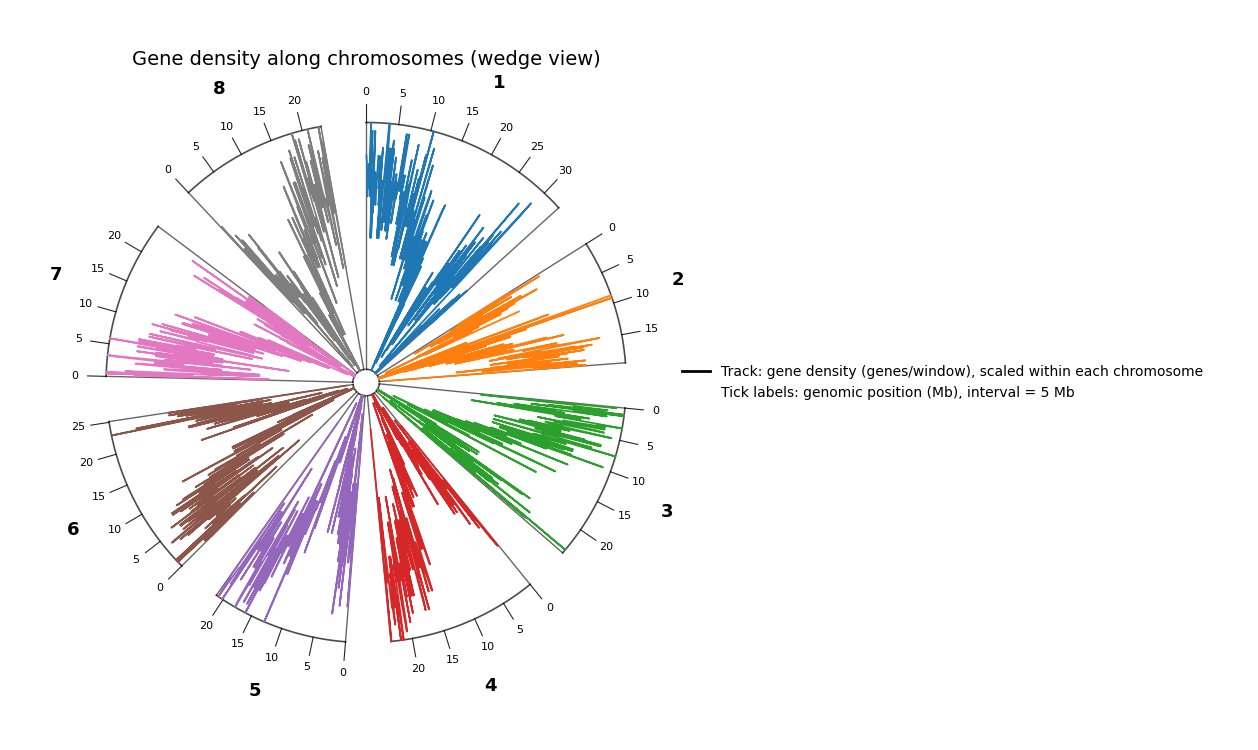

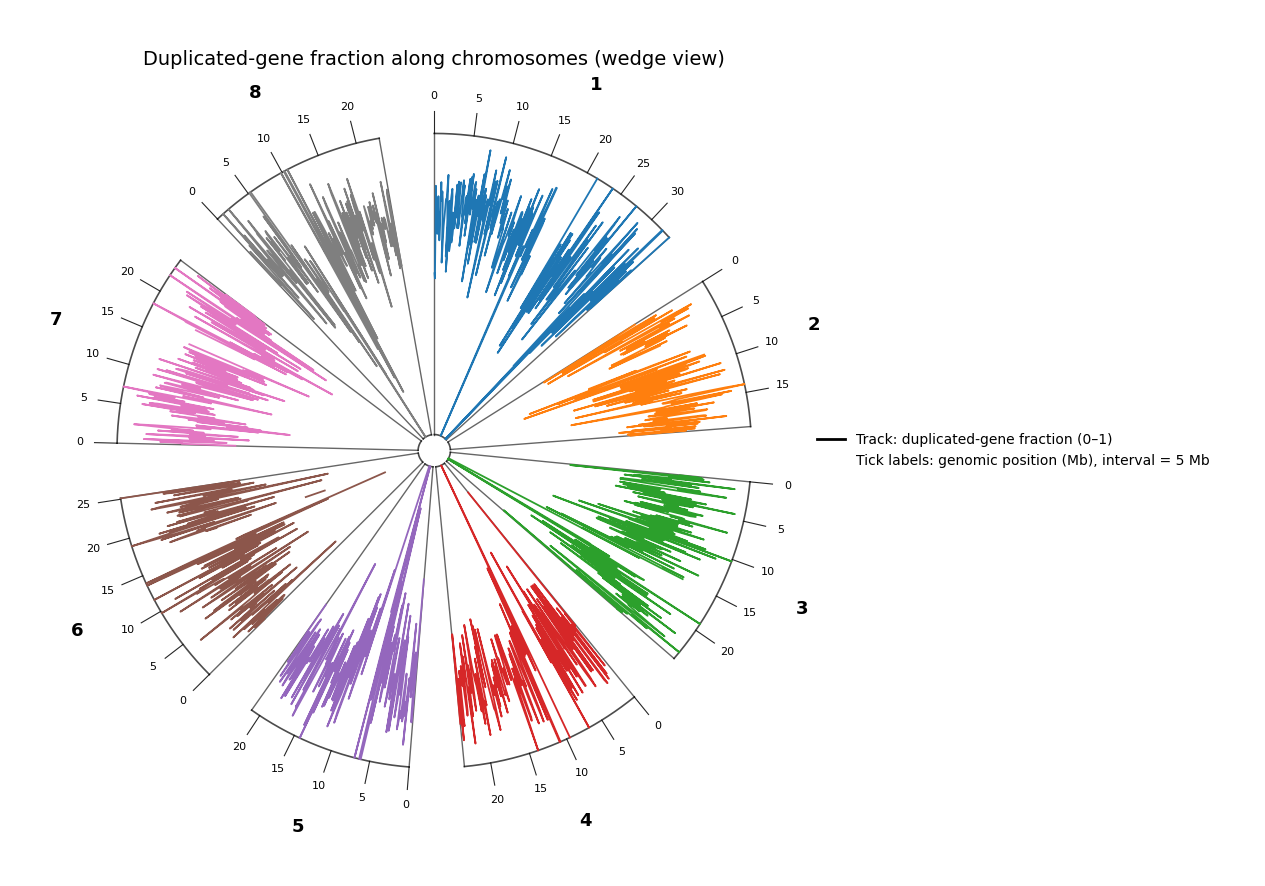

In [12]:
# ============================================================
# Two separate wedge-style circular plots (matplotlib polar):
#   1) Gene density per chromosome (genes per window)
#   2) Duplicated-gene fraction per chromosome (0..1)
#
# Changes requested:
#   - Separate figures (more readable)
#   - Legend moved to the side (no overlap)
#   - Clear Mb tick labels (0, 5, 10, 15, ...)
#
# EXPECTED INPUTS:
#   chrom_dup_profile[chrom] = (positions, n_all, n_dup, frac)
#   chrom_lengths[chrom] = length_bp
#
# NOTE:
#   The density track is scaled within each chromosome (1st..99th percentile -> 0..1)
#   so differences are visible even if one chromosome has a few extreme windows.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# -----------------------------
# Parameters you may adjust
# -----------------------------
MAIN_CHROMS = [str(i) for i in range(1, 9)]

START_ANGLE = np.pi / 2      # start at top
CLOCKWISE = True

GAP_DEG = 10
GAP_RAD = np.deg2rad(GAP_DEG)

# Wedge radii (one ring per figure)
R_INNER = 0.85
R_OUTER = 1.65

ARC_LW = 1.2
DIVIDER_LW = 1.0
LINE_LW = 1.3

# Tick labels in Mb
TICK_INTERVAL_BP = 5_000_000
TICK_LW = 0.8
TICK_LABEL_SIZE = 8
LABEL_RADIUS_PAD = 0.22

# Colors
CHR_COLORS = {
    "1": "tab:blue",
    "2": "tab:orange",
    "3": "tab:green",
    "4": "tab:red",
    "5": "tab:purple",
    "6": "tab:brown",
    "7": "tab:pink",
    "8": "tab:gray"
}

# -----------------------------
# Helpers
# -----------------------------
def x_to_theta(x_bp, chrom_len, sector_start, sector_span):
    """Map genomic positions (bp) into polar theta inside one sector."""
    return sector_start + (x_bp / chrom_len) * sector_span

def split_and_plot(ax, theta, r, color, lw):
    """Plot contiguous non-NaN segments to preserve gaps."""
    isn = np.isnan(r)
    seg_start = None
    for i in range(len(r)):
        if not isn[i] and seg_start is None:
            seg_start = i
        if (isn[i] or i == len(r) - 1) and seg_start is not None:
            seg_end = i if isn[i] else i + 1
            ax.plot(theta[seg_start:seg_end], r[seg_start:seg_end], color=color, lw=lw)
            seg_start = None

def compute_sector_angles(chroms_present, chrom_lengths, gap_rad):
    """Allocate sector spans proportional to chromosome length, with fixed gaps."""
    lengths = np.array([chrom_lengths[c] for c in chroms_present], dtype=float)
    total_len = lengths.sum()

    total_gap = len(chroms_present) * gap_rad
    available = 2 * np.pi - total_gap

    spans = {c: available * (chrom_lengths[c] / total_len) for c in chroms_present}

    starts = {}
    cursor = 0.0
    for c in chroms_present:
        starts[c] = cursor
        cursor += spans[c] + gap_rad

    return starts, spans

def draw_common_wedge_frame(ax, chrom, chrom_len, start, span, r_inner, r_outer,
                            arc_lw=1.2, divider_lw=1.0,
                            tick_interval_bp=5_000_000):
    """Draw wedge boundaries, arc frame, chromosome label, and Mb ticks."""
    end = start + span
    theta_arc = np.linspace(start, end, 300)

    # Sector boundary lines
    ax.plot([start, start], [r_inner, r_outer], color="black", lw=divider_lw, alpha=0.6)
    ax.plot([end, end],     [r_inner, r_outer], color="black", lw=divider_lw, alpha=0.6)

    # Arc frame
    ax.plot(theta_arc, np.full_like(theta_arc, r_inner), color="black", lw=arc_lw, alpha=0.7)
    ax.plot(theta_arc, np.full_like(theta_arc, r_outer), color="black", lw=arc_lw, alpha=0.7)

    # Chromosome label
    label_theta = start + span / 2
    ax.text(label_theta, r_outer + LABEL_RADIUS_PAD, chrom, ha="center", va="center",
            fontsize=13, fontweight="bold")

    # Mb ticks
    if tick_interval_bp is not None and chrom_len >= tick_interval_bp:
        tick_positions = np.arange(0, chrom_len + 1, tick_interval_bp)
        for tp in tick_positions:
            th = x_to_theta(tp, chrom_len, start, span)
            ax.plot([th, th], [r_outer, r_outer + 0.06], color="black", lw=TICK_LW, alpha=0.85)
            mb = int(tp / 1_000_000)
            ax.text(th, r_outer + 0.10, f"{mb}", ha="center", va="center", fontsize=TICK_LABEL_SIZE)

def make_base_polar_figure(title):
    """Create a clean polar axis with no default decorations."""
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_direction(-1 if CLOCKWISE else 1)
    ax.set_theta_offset(START_ANGLE)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["polar"].set_visible(False)
    plt.title(title, y=1.03, fontsize=14)
    return fig, ax

# -----------------------------
# Prepare chromosome order and sector geometry
# -----------------------------
chroms_present = [c for c in MAIN_CHROMS if (c in chrom_lengths) and (c in chrom_dup_profile)]
sector_starts, sector_spans = compute_sector_angles(chroms_present, chrom_lengths, GAP_RAD)

# ============================================================
# FIGURE 1: Gene density (genes per window)
# ============================================================
fig1, ax1 = make_base_polar_figure("Gene density along chromosomes (wedge view)")

for c in chroms_present:
    positions, n_all, n_dup, frac = chrom_dup_profile[c]
    chrom_len = chrom_lengths[c]

    start = sector_starts[c]
    span = sector_spans[c]
    color = CHR_COLORS.get(c, "black")

    draw_common_wedge_frame(
        ax1, c, chrom_len, start, span,
        r_inner=R_INNER, r_outer=R_OUTER,
        arc_lw=ARC_LW, divider_lw=DIVIDER_LW,
        tick_interval_bp=TICK_INTERVAL_BP
    )

    # Scale density robustly within chromosome to make differences visible
    dens = n_all.astype(float)
    dens_valid = dens[dens > 0]

    dens_scaled = np.full_like(dens, np.nan, dtype=float)
    if len(dens_valid) > 10:
        lo = np.percentile(dens_valid, 1)
        hi = np.percentile(dens_valid, 99)
        if hi <= lo:
            hi = lo + 1.0
        dens_scaled = (dens - lo) / (hi - lo)
        dens_scaled = np.clip(dens_scaled, 0, 1)
        dens_scaled[dens <= 0] = np.nan

    # Map scaled density [0..1] -> ring radius
    r = np.full_like(dens_scaled, np.nan, dtype=float)
    ok = ~np.isnan(dens_scaled)
    r[ok] = R_INNER + dens_scaled[ok] * (R_OUTER - R_INNER)

    theta = x_to_theta(positions, chrom_len, start, span)
    split_and_plot(ax1, theta, r, color=color, lw=LINE_LW)

# Side legend (no overlap)
legend1 = [
    Line2D([0], [0], color="black", lw=2, label="Track: gene density (genes/window), scaled within each chromosome"),
    Line2D([0], [0], color="black", lw=0, label=f"Tick labels: genomic position (Mb), interval = {TICK_INTERVAL_BP//1_000_000} Mb"),
]
ax1.legend(handles=legend1, loc="center left", bbox_to_anchor=(1.02, 0.5),
           frameon=False, fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================
# FIGURE 2: Duplicated-gene fraction (0..1)
# ============================================================
fig2, ax2 = make_base_polar_figure("Duplicated-gene fraction along chromosomes (wedge view)")

for c in chroms_present:
    positions, n_all, n_dup, frac = chrom_dup_profile[c]
    chrom_len = chrom_lengths[c]

    start = sector_starts[c]
    span = sector_spans[c]
    color = CHR_COLORS.get(c, "black")

    draw_common_wedge_frame(
        ax2, c, chrom_len, start, span,
        r_inner=R_INNER, r_outer=R_OUTER,
        arc_lw=ARC_LW, divider_lw=DIVIDER_LW,
        tick_interval_bp=TICK_INTERVAL_BP
    )

    # Map fraction [0..1] -> ring radius
    r = np.full_like(frac, np.nan, dtype=float)
    ok = ~np.isnan(frac)
    r[ok] = R_INNER + frac[ok] * (R_OUTER - R_INNER)

    theta = x_to_theta(positions, chrom_len, start, span)
    split_and_plot(ax2, theta, r, color=color, lw=LINE_LW)

# Side legend (no overlap)
legend2 = [
    Line2D([0], [0], color="black", lw=2, label="Track: duplicated-gene fraction (0–1)"),
    Line2D([0], [0], color="black", lw=0, label=f"Tick labels: genomic position (Mb), interval = {TICK_INTERVAL_BP//1_000_000} Mb"),
]
ax2.legend(handles=legend2, loc="center left", bbox_to_anchor=(1.02, 0.5),
           frameon=False, fontsize=10)

plt.tight_layout()
plt.show()


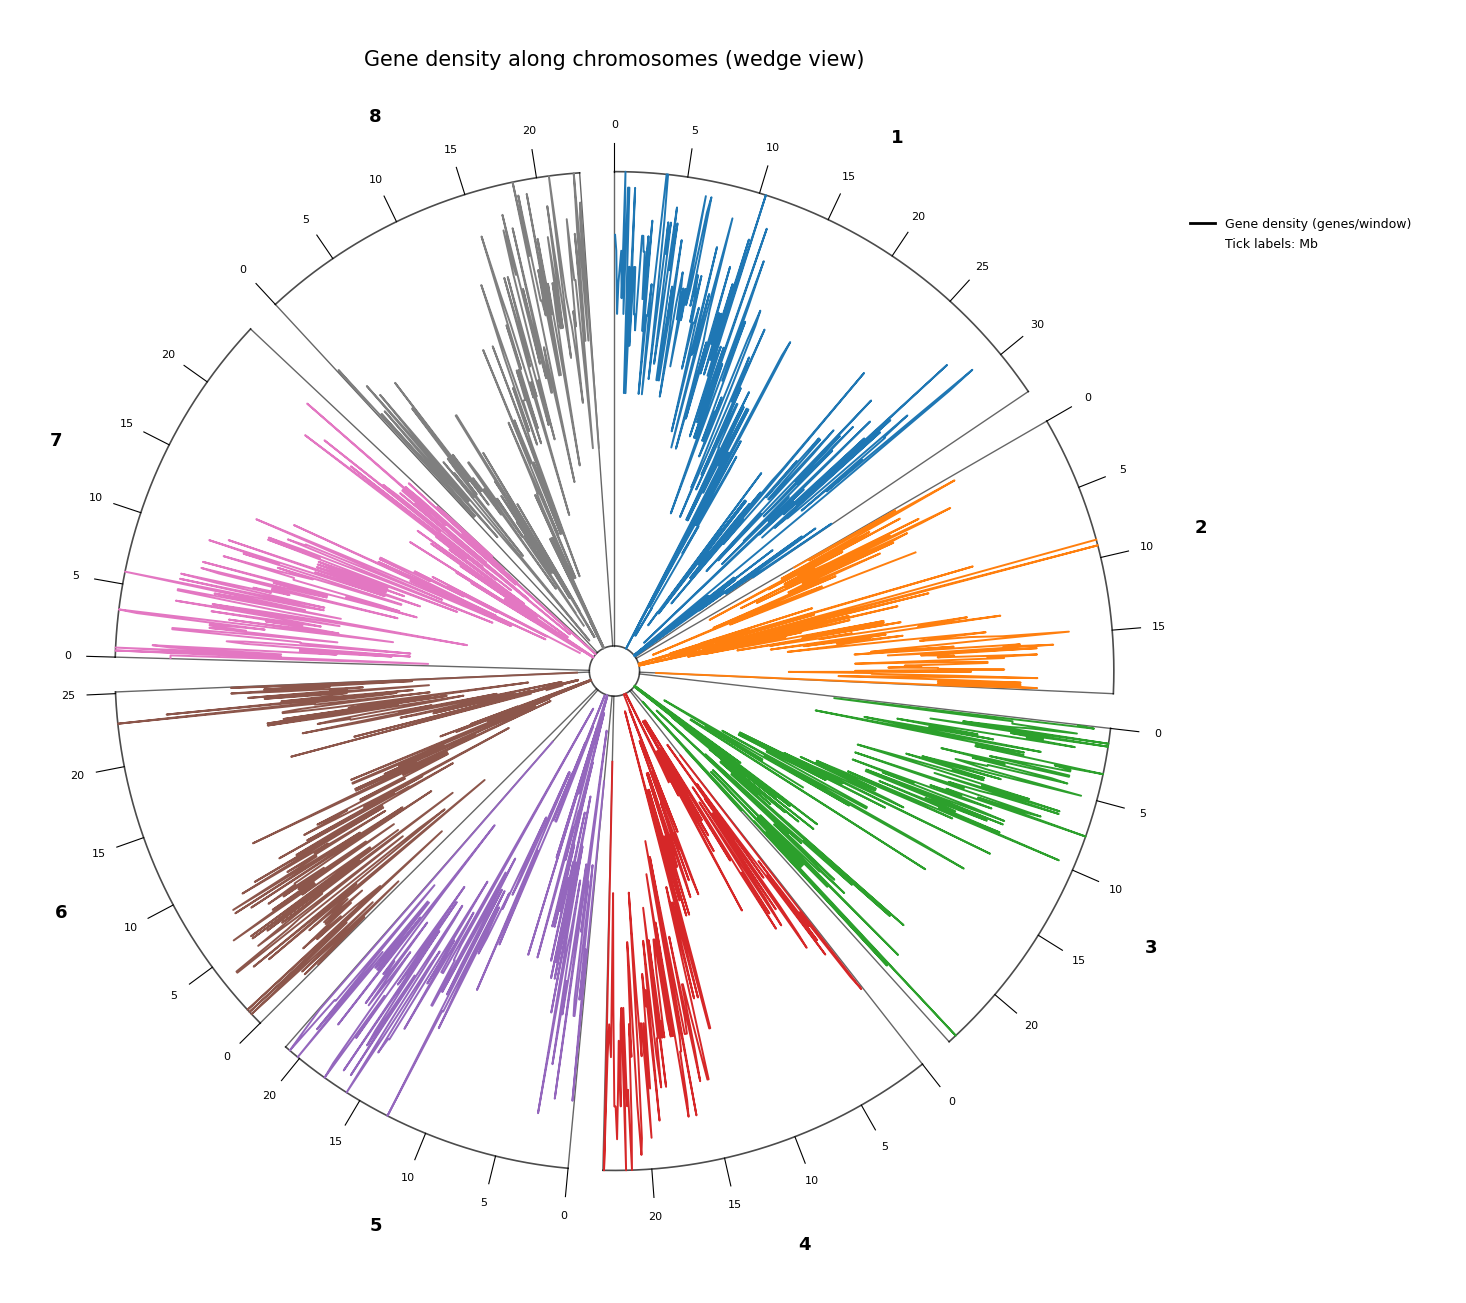

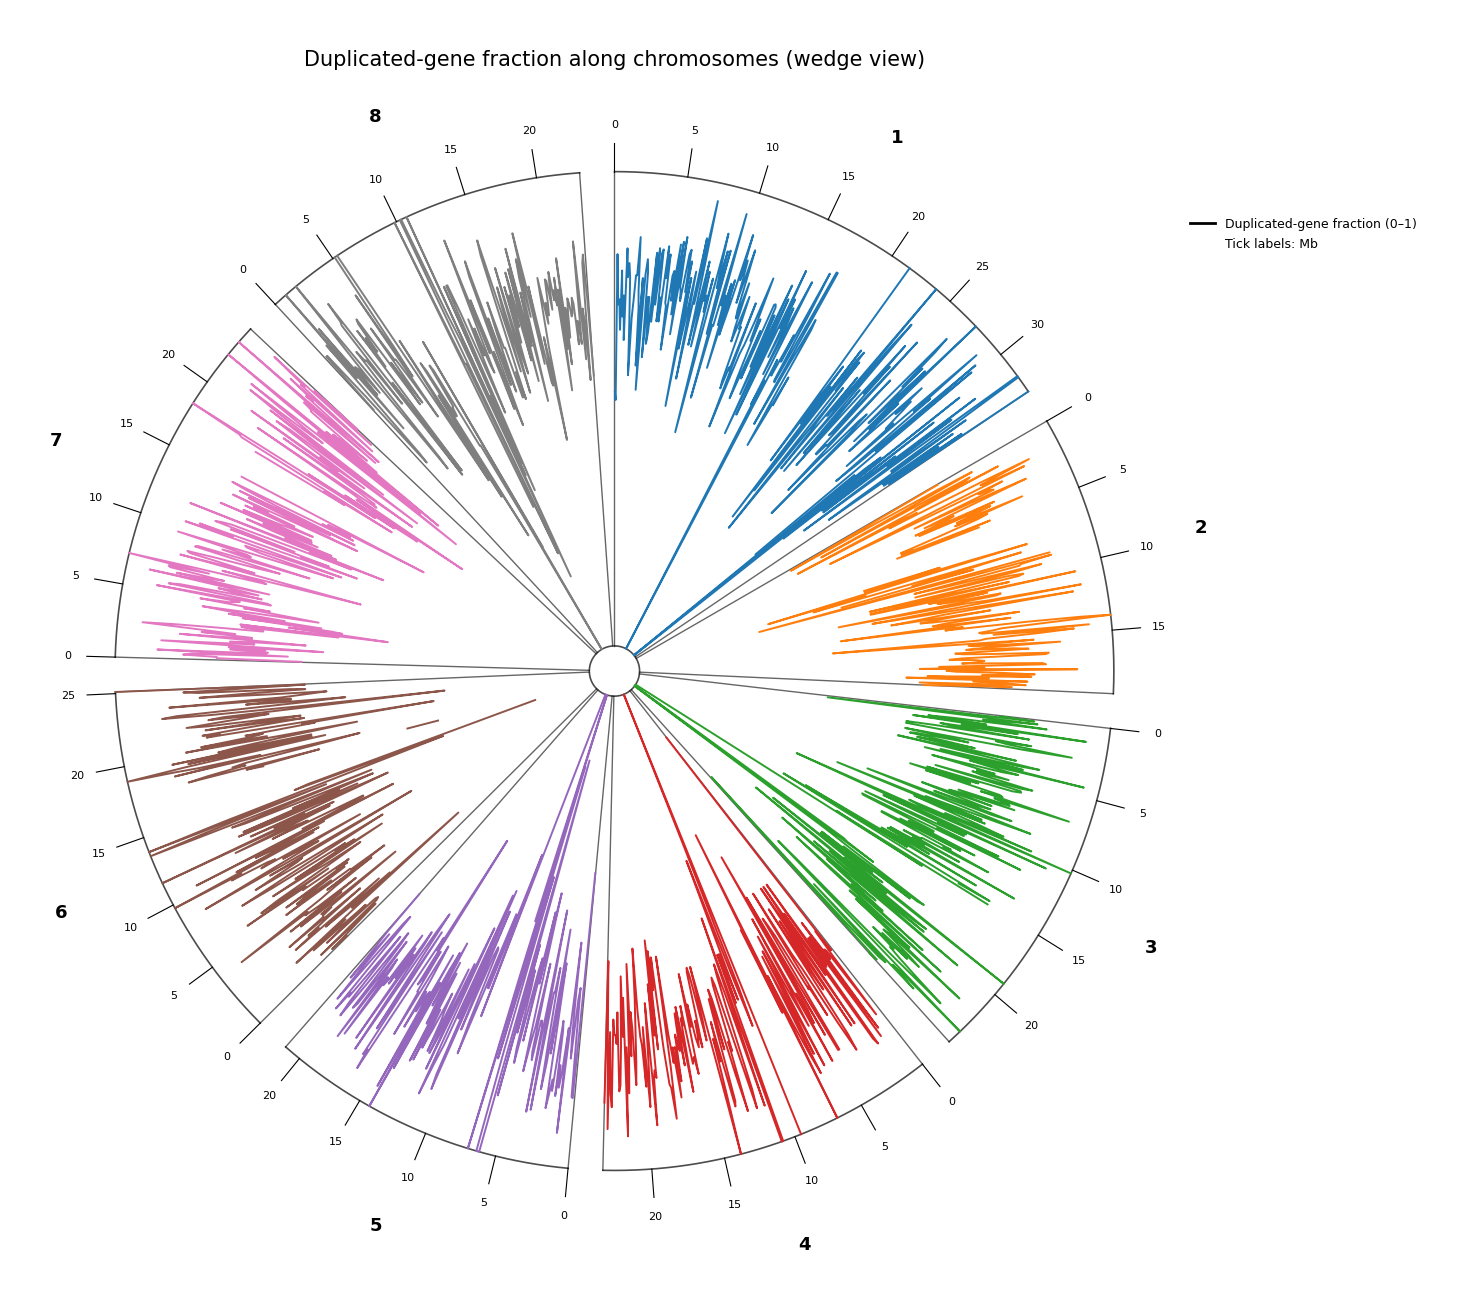

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# =========================
# Parameters you may adjust
# =========================

MAIN_CHROMS = [str(i) for i in range(1, 9)]  # "1".."8"

START_ANGLE = np.pi / 2   # start at top
CLOCKWISE = True

# ↓↓↓ smaller gap between wedges ↓↓↓
GAP_DEG = 4
GAP_RAD = np.deg2rad(GAP_DEG)

# ↓↓↓ thicker ring (better visibility) ↓↓↓
R_INNER = 0.75
R_OUTER = 1.75

ARC_LW = 1.2
DIVIDER_LW = 1.0
LINE_LW = 1.4

# Tick labels in Mb
TICK_INTERVAL_BP = 5_000_000
TICK_LW = 0.8
TICK_LABEL_SIZE = 8
LABEL_RADIUS_PAD = 0.22

# Colors per chromosome
CHR_COLORS = {
    "1": "tab:blue",
    "2": "tab:orange",
    "3": "tab:green",
    "4": "tab:red",
    "5": "tab:purple",
    "6": "tab:brown",
    "7": "tab:pink",
    "8": "tab:gray"
}

# =========================
# Helpers
# =========================

def x_to_theta(x_bp, chrom_len, sector_start, sector_span):
    """Map genomic position (bp) into polar theta inside one sector."""
    return sector_start + (x_bp / chrom_len) * sector_span

def split_and_plot(ax, theta, r, color, lw):
    """Plot contiguous non-NaN segments to preserve gaps."""
    isn = np.isnan(r)
    seg_start = None
    for i in range(len(r)):
        if not isn[i] and seg_start is None:
            seg_start = i
        if (isn[i] or i == len(r) - 1) and seg_start is not None:
            seg_end = i if isn[i] else i + 1
            ax.plot(theta[seg_start:seg_end], r[seg_start:seg_end],
                    color=color, lw=lw)
            seg_start = None

def compute_sector_angles(chroms_present, chrom_lengths, gap_rad):
    """Allocate sector spans proportional to chromosome length, with fixed gaps."""
    lengths = np.array([chrom_lengths[c] for c in chroms_present], dtype=float)
    total_len = lengths.sum()

    total_gap = len(chroms_present) * gap_rad
    available = 2 * np.pi - total_gap

    spans = {c: available * (chrom_lengths[c] / total_len)
             for c in chroms_present}

    starts = {}
    cursor = 0.0
    for c in chroms_present:
        starts[c] = cursor
        cursor += spans[c] + gap_rad

    return starts, spans

def draw_common_wedge_frame(ax, chrom, chrom_len, start, span,
                           r_inner, r_outer,
                           arc_lw=1.2, divider_lw=1.0,
                           tick_interval_bp=5_000_000):
    """Draw wedge boundaries, arc frame, chromosome label, and Mb ticks."""
    end = start + span
    theta_arc = np.linspace(start, end, 300)

    # Sector borders
    ax.plot([start, start], [r_inner, r_outer],
            color="black", lw=divider_lw, alpha=0.6)
    ax.plot([end, end], [r_inner, r_outer],
            color="black", lw=divider_lw, alpha=0.6)

    # Arc frame
    ax.plot(theta_arc, np.full_like(theta_arc, r_inner),
            color="black", lw=arc_lw, alpha=0.7)
    ax.plot(theta_arc, np.full_like(theta_arc, r_outer),
            color="black", lw=arc_lw, alpha=0.7)

    # Chromosome label
    label_theta = start + span / 2
    ax.text(label_theta, r_outer + LABEL_RADIUS_PAD, chrom,
            ha="center", va="center",
            fontsize=13, fontweight="bold")

    # Mb ticks
    if tick_interval_bp and chrom_len >= tick_interval_bp:
        for tp in np.arange(0, chrom_len + 1, tick_interval_bp):
            th = x_to_theta(tp, chrom_len, start, span)
            ax.plot([th, th], [r_outer, r_outer + 0.06],
                    color="black", lw=TICK_LW)
            ax.text(th, r_outer + 0.10,
                    f"{int(tp / 1_000_000)}",
                    ha="center", va="center",
                    fontsize=TICK_LABEL_SIZE)

def make_base_polar_figure(title):
    """Create a clean polar axis with consistent sizing."""
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(111, polar=True)

    ax.set_theta_direction(-1 if CLOCKWISE else 1)
    ax.set_theta_offset(START_ANGLE)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["polar"].set_visible(False)

    plt.title(title, y=1.04, fontsize=15)
    return fig, ax

# =========================
# Prepare geometry
# =========================

chroms_present = [
    c for c in MAIN_CHROMS
    if c in chrom_lengths and c in chrom_dup_profile
]

sector_starts, sector_spans = compute_sector_angles(
    chroms_present, chrom_lengths, GAP_RAD
)

# ==================================================
# FIGURE 1: Gene density
# ==================================================

fig1, ax1 = make_base_polar_figure(
    "Gene density along chromosomes (wedge view)"
)

for c in chroms_present:
    positions, n_all, _, _ = chrom_dup_profile[c]
    chrom_len = chrom_lengths[c]
    start, span = sector_starts[c], sector_spans[c]
    color = CHR_COLORS.get(c, "black")

    draw_common_wedge_frame(
        ax1, c, chrom_len, start, span,
        R_INNER, R_OUTER
    )

    dens = n_all.astype(float)
    dens_valid = dens[dens > 0]

    dens_scaled = np.full_like(dens, np.nan)
    if len(dens_valid) > 10:
        lo, hi = np.percentile(dens_valid, [1, 99])
        hi = max(hi, lo + 1)
        dens_scaled = np.clip((dens - lo) / (hi - lo), 0, 1)
        dens_scaled[dens <= 0] = np.nan

    r = R_INNER + dens_scaled * (R_OUTER - R_INNER)
    theta = x_to_theta(positions, chrom_len, start, span)
    split_and_plot(ax1, theta, r, color, LINE_LW)

ax1.legend(
    handles=[
        Line2D([0], [0], color="black", lw=2,
               label="Gene density (genes/window)"),
        Line2D([0], [0], color="black", lw=0,
               label="Tick labels: Mb")
    ],
    loc="upper left",
    bbox_to_anchor=(1.01, 0.92),
    frameon=False,
    fontsize=9
)

plt.subplots_adjust(left=0.03, right=0.82, top=0.92, bottom=0.05)
plt.show()

# ==================================================
# FIGURE 2: Duplicated-gene fraction
# ==================================================

fig2, ax2 = make_base_polar_figure(
    "Duplicated-gene fraction along chromosomes (wedge view)"
)

for c in chroms_present:
    positions, _, _, frac = chrom_dup_profile[c]
    chrom_len = chrom_lengths[c]
    start, span = sector_starts[c], sector_spans[c]
    color = CHR_COLORS.get(c, "black")

    draw_common_wedge_frame(
        ax2, c, chrom_len, start, span,
        R_INNER, R_OUTER
    )

    r = R_INNER + frac * (R_OUTER - R_INNER)
    theta = x_to_theta(positions, chrom_len, start, span)
    split_and_plot(ax2, theta, r, color, LINE_LW)

ax2.legend(
    handles=[
        Line2D([0], [0], color="black", lw=2,
               label="Duplicated-gene fraction (0–1)"),
        Line2D([0], [0], color="black", lw=0,
               label="Tick labels: Mb")
    ],
    loc="upper left",
    bbox_to_anchor=(1.01, 0.92),
    frameon=False,
    fontsize=9
)

plt.subplots_adjust(left=0.03, right=0.82, top=0.92, bottom=0.05)
plt.show()
